<a href="https://colab.research.google.com/github/AditiKamble06/Hackathon1/blob/main/Hackathon2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydantic==1.10.2 pandas-profiling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pf
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.5/359.5 kB 26.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of ydata-profiling to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.9/357.9 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.9/357.9 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.8/357.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.6/357.6 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/usr/local/lib/python3.10/dist-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
<ipython-input-1-02681026af30>:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling`

In [2]:
train = pd.read_csv('./training_set_features.csv', index_col='respondent_id')
test = pd.read_csv('./test_set_features.csv', index_col='respondent_id')
labels = pd.read_csv('./training_set_labels.csv', index_col='respondent_id')

In [3]:
num_cols = train.select_dtypes('number').columns
cat_cols = ['race', 'sex',
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']
ord_cols = ['age_group', 'education',  'income_poverty',
        'employment_status']
assert len(num_cols)+len(cat_cols)+len(ord_cols) == train.shape[1]

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
!pip install category_encoders catboost
from category_encoders import OrdinalEncoder as oe
from catboost import CatBoostClassifier
from catboost import Pool, cv
from sklearn.metrics import roc_curve, roc_auc_score
!pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.5 MB/s eta 0:00:00


In [7]:
for col in (cat_cols+ord_cols):
    train[col] = train[col].fillna(value='None')

In [8]:
for col in num_cols:
    train[col] = train[col].fillna(value=-1)

In [9]:
for col in (cat_cols+ord_cols):
    test[col] = test[col].fillna(value='None')

In [10]:
for col in num_cols:
    test[col] = test[col].fillna(value=-1)

In [11]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( train, labels, test_size=0.3, random_state=68)

In [13]:
categorical_features_indices = np.where(X_train.dtypes != float)[0]

In [15]:
train_dataset = Pool(data=X_train,
                     label=y_train.xyz_vaccine,
                     cat_features = categorical_features_indices)

In [16]:
def objective(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
         'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

    scores = cv(train_dataset,
            param,
            fold_count=5,
            early_stopping_rounds=10,
            plot=False, verbose=False)

    return scores['test-AUC-mean'].max()

In [17]:
sampler = optuna.samplers.TPESampler(seed=68)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2024-06-17 11:07:33,327] A new study created in memory with name: no-name-bb7af965-e92c-4e32-aa17-3391ea1262ae
<ipython-input-16-85eac53102f7>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),


Training on fold [0/5]

bestTest = 0.426979142
bestIteration = 516

Training on fold [1/5]

bestTest = 0.4202580663
bestIteration = 604

Training on fold [2/5]

bestTest = 0.4318418235
bestIteration = 579

Training on fold [3/5]

bestTest = 0.4282363143
bestIteration = 486

Training on fold [4/5]


[I 2024-06-17 11:07:48,836] Trial 0 finished with value: 0.8639853018790097 and parameters: {'iterations': 1500, 'learning_rate': 0.029356482739949695, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 4, 'l2_leaf_reg': 0.001991194871120998, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8639853018790097.



bestTest = 0.433461424
bestIteration = 441

Training on fold [0/5]

bestTest = 0.4269683106
bestIteration = 129

Training on fold [1/5]

bestTest = 0.419469944
bestIteration = 192

Training on fold [2/5]

bestTest = 0.4291868644
bestIteration = 153

Training on fold [3/5]

bestTest = 0.4268945898
bestIteration = 125

Training on fold [4/5]


[I 2024-06-17 11:07:53,916] Trial 1 finished with value: 0.8634485451090079 and parameters: {'iterations': 200, 'learning_rate': 0.1464067066361795, 'random_strength': 10, 'bagging_temperature': 3, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 3, 'l2_leaf_reg': 0.028402775147703313, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8639853018790097.



bestTest = 0.4316683101
bestIteration = 116

Training on fold [0/5]

bestTest = 0.4317784377
bestIteration = 59

Training on fold [1/5]

bestTest = 0.4277696752
bestIteration = 53

Training on fold [2/5]

bestTest = 0.4381016884
bestIteration = 55

Training on fold [3/5]

bestTest = 0.429156628
bestIteration = 45

Training on fold [4/5]


[I 2024-06-17 11:08:01,851] Trial 2 finished with value: 0.8587802511846505 and parameters: {'iterations': 200, 'learning_rate': 0.27287829596201946, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.027330135035255495, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8639853018790097.



bestTest = 0.4371631566
bestIteration = 36

Training on fold [0/5]

bestTest = 0.42775248
bestIteration = 508

Training on fold [1/5]

bestTest = 0.4220194733
bestIteration = 520

Training on fold [2/5]

bestTest = 0.4301315758
bestIteration = 583

Training on fold [3/5]

bestTest = 0.4276900124
bestIteration = 453

Training on fold [4/5]


[I 2024-06-17 11:08:36,768] Trial 3 finished with value: 0.8637170542070158 and parameters: {'iterations': 1200, 'learning_rate': 0.0603209284932487, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 2, 'l2_leaf_reg': 1.300471404766049e-07, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8639853018790097.



bestTest = 0.4329737808
bestIteration = 410

Training on fold [0/5]

bestTest = 0.4348989187
bestIteration = 73

Training on fold [1/5]

bestTest = 0.4242069741
bestIteration = 72

Training on fold [2/5]

bestTest = 0.4390889248
bestIteration = 62

Training on fold [3/5]

bestTest = 0.4353451465
bestIteration = 61

Training on fold [4/5]


[I 2024-06-17 11:08:41,347] Trial 4 finished with value: 0.8585707597133918 and parameters: {'iterations': 300, 'learning_rate': 0.22423670437233847, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 0.00010293033487726667, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8639853018790097.



bestTest = 0.4353386179
bestIteration = 85

Training on fold [0/5]

bestTest = 0.4864381663
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4848345544
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4918852624
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4857292621
bestIteration = 99

Training on fold [4/5]


[I 2024-06-17 11:08:44,957] Trial 5 finished with value: 0.8516669599668087 and parameters: {'iterations': 100, 'learning_rate': 0.06628011038512191, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 2, 'l2_leaf_reg': 13.751833235431702, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8639853018790097.



bestTest = 0.4919259887
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4307915324
bestIteration = 98

Training on fold [1/5]

bestTest = 0.4226802156
bestIteration = 70

Training on fold [2/5]

bestTest = 0.4334947317
bestIteration = 124

Training on fold [3/5]

bestTest = 0.436377036
bestIteration = 80

Training on fold [4/5]


[I 2024-06-17 11:09:18,481] Trial 6 finished with value: 0.8616877078561375 and parameters: {'iterations': 1200, 'learning_rate': 0.09658215406978513, 'random_strength': 8, 'bagging_temperature': 2, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 2.6558249848041764, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8639853018790097.



bestTest = 0.4293134391
bestIteration = 100

Training on fold [0/5]

bestTest = 0.4628058006
bestIteration = 114

Training on fold [1/5]

bestTest = 0.4546820079
bestIteration = 91

Training on fold [2/5]

bestTest = 0.4642139758
bestIteration = 90

Training on fold [3/5]

bestTest = 0.4627206828
bestIteration = 108

Training on fold [4/5]


[I 2024-06-17 11:09:21,838] Trial 7 finished with value: 0.8627165403544652 and parameters: {'iterations': 500, 'learning_rate': 0.2714096381817127, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 4.9369231964322795, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8639853018790097.



bestTest = 0.4649959281
bestIteration = 107

Training on fold [0/5]

bestTest = 0.4284500585
bestIteration = 82

Training on fold [1/5]

bestTest = 0.4210011606
bestIteration = 116

Training on fold [2/5]

bestTest = 0.4323507379
bestIteration = 129

Training on fold [3/5]

bestTest = 0.4281232857
bestIteration = 75

Training on fold [4/5]


[I 2024-06-17 11:09:25,822] Trial 8 finished with value: 0.8625807103079209 and parameters: {'iterations': 1500, 'learning_rate': 0.2053434310118264, 'random_strength': 8, 'bagging_temperature': 0, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 3, 'l2_leaf_reg': 9.501510078266123e-06, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8639853018790097.



bestTest = 0.4320438131
bestIteration = 95

Training on fold [0/5]

bestTest = 0.433843025
bestIteration = 43

Training on fold [1/5]

bestTest = 0.441881146
bestIteration = 26

Training on fold [2/5]

bestTest = 0.4485761573
bestIteration = 33

Training on fold [3/5]

bestTest = 0.4471908719
bestIteration = 36

Training on fold [4/5]


[I 2024-06-17 11:09:36,931] Trial 9 finished with value: 0.8529892215730064 and parameters: {'iterations': 100, 'learning_rate': 0.25900665720714294, 'random_strength': 3, 'bagging_temperature': 0, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 1.1694576328936887e-07, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8639853018790097.



bestTest = 0.4440165195
bestIteration = 26

Training on fold [0/5]

bestTest = 0.4819553673
bestIteration = 815

Training on fold [1/5]

bestTest = 0.4688637361
bestIteration = 1042

Training on fold [2/5]

bestTest = 0.4800854506
bestIteration = 1078

Training on fold [3/5]

bestTest = 0.4747438813
bestIteration = 1026

Training on fold [4/5]


[I 2024-06-17 11:10:22,250] Trial 10 finished with value: 0.8569875080963157 and parameters: {'iterations': 1500, 'learning_rate': 0.006050647464439535, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 0.007150186521078322, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8639853018790097.



bestTest = 0.4765475736
bestIteration = 1202

Training on fold [0/5]

bestTest = 0.432711909
bestIteration = 999

Training on fold [1/5]

bestTest = 0.4300468672
bestIteration = 999

Training on fold [2/5]

bestTest = 0.439344334
bestIteration = 999

Training on fold [3/5]

bestTest = 0.4321047068
bestIteration = 999

Training on fold [4/5]


[I 2024-06-17 11:12:20,457] Trial 11 finished with value: 0.8611204466068939 and parameters: {'iterations': 1000, 'learning_rate': 0.006258402413494596, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 5, 'l2_leaf_reg': 3.7395625169299806e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8639853018790097.



bestTest = 0.4367930914
bestIteration = 999

Training on fold [0/5]

bestTest = 0.4326194631
bestIteration = 174

Training on fold [1/5]

bestTest = 0.4245043924
bestIteration = 291

Training on fold [2/5]

bestTest = 0.4350353228
bestIteration = 227

Training on fold [3/5]

bestTest = 0.4305405473
bestIteration = 183

Training on fold [4/5]


[I 2024-06-17 11:12:27,910] Trial 12 finished with value: 0.861295775425228 and parameters: {'iterations': 1200, 'learning_rate': 0.06725819830482033, 'random_strength': 6, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 2.484887686602948e-06, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8639853018790097.



bestTest = 0.4315634071
bestIteration = 215

Training on fold [0/5]

bestTest = 0.4269752155
bestIteration = 229

Training on fold [1/5]

bestTest = 0.4199364901
bestIteration = 360

Training on fold [2/5]

bestTest = 0.4302774594
bestIteration = 254

Training on fold [3/5]

bestTest = 0.4252914531
bestIteration = 259

Training on fold [4/5]


[I 2024-06-17 11:12:44,234] Trial 13 finished with value: 0.8645721157519723 and parameters: {'iterations': 1200, 'learning_rate': 0.11844354640975294, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 2, 'l2_leaf_reg': 0.0005293545363842097, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8645721157519723.



bestTest = 0.4313216624
bestIteration = 215

Training on fold [0/5]

bestTest = 0.4318682923
bestIteration = 44

Training on fold [1/5]

bestTest = 0.4268716122
bestIteration = 54

Training on fold [2/5]

bestTest = 0.4389489325
bestIteration = 73

Training on fold [3/5]

bestTest = 0.4342025492
bestIteration = 54

Training on fold [4/5]


[I 2024-06-17 11:12:54,705] Trial 14 finished with value: 0.8592337847557016 and parameters: {'iterations': 1500, 'learning_rate': 0.13150291582573478, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 0.0004751545993241495, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8645721157519723.



bestTest = 0.4372130674
bestIteration = 60

Training on fold [0/5]

bestTest = 0.4670124723
bestIteration = 73

Training on fold [1/5]

bestTest = 0.4607693835
bestIteration = 70

Training on fold [2/5]

bestTest = 0.4685749432
bestIteration = 66

Training on fold [3/5]

bestTest = 0.4685308362
bestIteration = 69

Training on fold [4/5]


[I 2024-06-17 11:13:09,217] Trial 15 finished with value: 0.8593235261864474 and parameters: {'iterations': 1000, 'learning_rate': 0.18379968329218066, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 10, 'l2_leaf_reg': 0.2794285934522289, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8645721157519723.



bestTest = 0.4684014216
bestIteration = 71

Training on fold [0/5]

bestTest = 0.4279894877
bestIteration = 136

Training on fold [1/5]

bestTest = 0.4251162105
bestIteration = 102

Training on fold [2/5]

bestTest = 0.4348660759
bestIteration = 91

Training on fold [3/5]

bestTest = 0.4281975284
bestIteration = 90

Training on fold [4/5]


[I 2024-06-17 11:13:12,247] Trial 16 finished with value: 0.8616372134351991 and parameters: {'iterations': 500, 'learning_rate': 0.10406308911058082, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 6.80996375335814e-05, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8645721157519723.



bestTest = 0.4359476043
bestIteration = 86

Training on fold [0/5]

bestTest = 0.437179863
bestIteration = 297

Training on fold [1/5]

bestTest = 0.4340263636
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4424426352
bestIteration = 299

Training on fold [3/5]

bestTest = 0.434417072
bestIteration = 299

Training on fold [4/5]


[I 2024-06-17 11:13:36,291] Trial 17 finished with value: 0.8592179620697367 and parameters: {'iterations': 300, 'learning_rate': 0.035256540040725835, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 3, 'l2_leaf_reg': 0.0030542199837083703, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8645721157519723.



bestTest = 0.4421929818
bestIteration = 297

Training on fold [0/5]

bestTest = 0.4722047264
bestIteration = 100

Training on fold [1/5]

bestTest = 0.465302506
bestIteration = 91

Training on fold [2/5]

bestTest = 0.4744953637
bestIteration = 100

Training on fold [3/5]

bestTest = 0.4757180457
bestIteration = 65

Training on fold [4/5]


[I 2024-06-17 11:13:41,507] Trial 18 finished with value: 0.8568085308432254 and parameters: {'iterations': 1500, 'learning_rate': 0.10754230079730588, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 8, 'l2_leaf_reg': 0.27380132206726326, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8645721157519723.



bestTest = 0.4766777062
bestIteration = 83

Training on fold [0/5]

bestTest = 0.4251741375
bestIteration = 467

Training on fold [1/5]

bestTest = 0.4160313198
bestIteration = 500

Training on fold [2/5]

bestTest = 0.4248866882
bestIteration = 636

Training on fold [3/5]

bestTest = 0.4231781997
bestIteration = 455

Training on fold [4/5]


[I 2024-06-17 11:15:08,768] Trial 19 finished with value: 0.8670259061253984 and parameters: {'iterations': 1200, 'learning_rate': 0.03457949514742683, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 99.11695455168572, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.4268745408
bestIteration = 441

Training on fold [0/5]

bestTest = 0.4226404564
bestIteration = 94

Training on fold [1/5]

bestTest = 0.4169211354
bestIteration = 111

Training on fold [2/5]

bestTest = 0.4243037673
bestIteration = 102

Training on fold [3/5]

bestTest = 0.4271240697
bestIteration = 82

Training on fold [4/5]


[I 2024-06-17 11:15:33,254] Trial 20 finished with value: 0.8661016909019124 and parameters: {'iterations': 1200, 'learning_rate': 0.17019901906103235, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 9, 'l2_leaf_reg': 82.78307909643196, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.4291289285
bestIteration = 102

Training on fold [0/5]

bestTest = 0.4268869192
bestIteration = 80

Training on fold [1/5]

bestTest = 0.4182661618
bestIteration = 104

Training on fold [2/5]

bestTest = 0.4267312228
bestIteration = 94

Training on fold [3/5]

bestTest = 0.4266925699
bestIteration = 72

Training on fold [4/5]


[I 2024-06-17 11:15:50,709] Trial 21 finished with value: 0.8648597586863316 and parameters: {'iterations': 1200, 'learning_rate': 0.1813402925138622, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 9, 'l2_leaf_reg': 97.05967522169827, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.4289310872
bestIteration = 94

Training on fold [0/5]

bestTest = 0.4251795894
bestIteration = 93

Training on fold [1/5]

bestTest = 0.4179933386
bestIteration = 90

Training on fold [2/5]

bestTest = 0.428032481
bestIteration = 94

Training on fold [3/5]

bestTest = 0.4221597745
bestIteration = 75

Training on fold [4/5]


[I 2024-06-17 11:16:11,407] Trial 22 finished with value: 0.8661818875226575 and parameters: {'iterations': 1200, 'learning_rate': 0.17742863503226816, 'random_strength': 5, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 9, 'l2_leaf_reg': 91.69888044927987, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.4261635669
bestIteration = 94

Training on fold [0/5]

bestTest = 0.4257741932
bestIteration = 108

Training on fold [1/5]

bestTest = 0.4179048646
bestIteration = 127

Training on fold [2/5]

bestTest = 0.4220293694
bestIteration = 144

Training on fold [3/5]

bestTest = 0.4238460839
bestIteration = 89

Training on fold [4/5]


[I 2024-06-17 11:16:38,313] Trial 23 finished with value: 0.8663092950446792 and parameters: {'iterations': 1200, 'learning_rate': 0.16853766962373737, 'random_strength': 7, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 9, 'l2_leaf_reg': 89.94436397893038, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.426360908
bestIteration = 128

Training on fold [0/5]

bestTest = 0.4297560878
bestIteration = 56

Training on fold [1/5]

bestTest = 0.4234566732
bestIteration = 69

Training on fold [2/5]

bestTest = 0.4303449646
bestIteration = 72

Training on fold [3/5]

bestTest = 0.432341963
bestIteration = 56

Training on fold [4/5]


[I 2024-06-17 11:16:50,818] Trial 24 finished with value: 0.8621559413384906 and parameters: {'iterations': 1200, 'learning_rate': 0.22901862705036102, 'random_strength': 7, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 8, 'l2_leaf_reg': 0.8819361741496402, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.4305911397
bestIteration = 55

Training on fold [0/5]

bestTest = 0.4245140363
bestIteration = 92

Training on fold [1/5]

bestTest = 0.4203832495
bestIteration = 93

Training on fold [2/5]

bestTest = 0.4270338456
bestIteration = 94

Training on fold [3/5]

bestTest = 0.4280417525
bestIteration = 88

Training on fold [4/5]


[I 2024-06-17 11:17:08,593] Trial 25 finished with value: 0.864807106351132 and parameters: {'iterations': 1200, 'learning_rate': 0.1679348262267533, 'random_strength': 7, 'bagging_temperature': 5, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 9, 'l2_leaf_reg': 17.221340282901554, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.4262343013
bestIteration = 95

Training on fold [0/5]

bestTest = 0.425672306
bestIteration = 73

Training on fold [1/5]

bestTest = 0.4214922292
bestIteration = 89

Training on fold [2/5]

bestTest = 0.4256511798
bestIteration = 82

Training on fold [3/5]

bestTest = 0.4289957257
bestIteration = 62

Training on fold [4/5]


[I 2024-06-17 11:17:23,523] Trial 26 finished with value: 0.8645217196615558 and parameters: {'iterations': 1200, 'learning_rate': 0.1995311665881793, 'random_strength': 6, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 7, 'l2_leaf_reg': 17.843392697641264, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.4274847293
bestIteration = 72

Training on fold [0/5]

bestTest = 0.4608481406
bestIteration = 100

Training on fold [1/5]

bestTest = 0.4540013376
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4619772197
bestIteration = 101

Training on fold [3/5]

bestTest = 0.4637453634
bestIteration = 97

Training on fold [4/5]


[I 2024-06-17 11:17:43,190] Trial 27 finished with value: 0.8631447596968049 and parameters: {'iterations': 1200, 'learning_rate': 0.1407938710864717, 'random_strength': 9, 'bagging_temperature': 4, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 0.8368908731025517, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.4642721641
bestIteration = 95

Training on fold [0/5]

bestTest = 0.4296142173
bestIteration = 49

Training on fold [1/5]

bestTest = 0.4181045164
bestIteration = 65

Training on fold [2/5]

bestTest = 0.4264944711
bestIteration = 53

Training on fold [3/5]

bestTest = 0.4288274342
bestIteration = 45

Training on fold [4/5]


[I 2024-06-17 11:17:54,481] Trial 28 finished with value: 0.8642258312443643 and parameters: {'iterations': 1200, 'learning_rate': 0.29978865396215293, 'random_strength': 4, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 8, 'l2_leaf_reg': 67.71278102376614, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.4281808033
bestIteration = 44

Training on fold [0/5]

bestTest = 0.426442267
bestIteration = 162

Training on fold [1/5]

bestTest = 0.4170120587
bestIteration = 171

Training on fold [2/5]

bestTest = 0.429044176
bestIteration = 180

Training on fold [3/5]

bestTest = 0.4261306918
bestIteration = 150

Training on fold [4/5]


[I 2024-06-17 11:18:23,239] Trial 29 finished with value: 0.8646031408271778 and parameters: {'iterations': 1000, 'learning_rate': 0.08777588409760562, 'random_strength': 7, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 10, 'l2_leaf_reg': 0.06851010003292098, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.4290129097
bestIteration = 152

Training on fold [0/5]

bestTest = 0.4305312958
bestIteration = 88

Training on fold [1/5]

bestTest = 0.4213376699
bestIteration = 98

Training on fold [2/5]

bestTest = 0.4291961828
bestIteration = 87

Training on fold [3/5]

bestTest = 0.4270698653
bestIteration = 85

Training on fold [4/5]


[I 2024-06-17 11:18:30,771] Trial 30 finished with value: 0.864193347927994 and parameters: {'iterations': 100, 'learning_rate': 0.15829306972224438, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 5, 'l2_leaf_reg': 4.571972387109759, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.4264629137
bestIteration = 98

Training on fold [0/5]

bestTest = 0.4230128588
bestIteration = 95

Training on fold [1/5]

bestTest = 0.4202414396
bestIteration = 102

Training on fold [2/5]

bestTest = 0.4256026647
bestIteration = 119

Training on fold [3/5]

bestTest = 0.4233691241
bestIteration = 78

Training on fold [4/5]


[I 2024-06-17 11:18:50,431] Trial 31 finished with value: 0.8655267130546399 and parameters: {'iterations': 1200, 'learning_rate': 0.17277640282526008, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 9, 'l2_leaf_reg': 91.3733152519072, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.4293021186
bestIteration = 82

Training on fold [0/5]

bestTest = 0.4307681798
bestIteration = 68

Training on fold [1/5]

bestTest = 0.4228741358
bestIteration = 76

Training on fold [2/5]

bestTest = 0.4256016286
bestIteration = 98

Training on fold [3/5]

bestTest = 0.4308980148
bestIteration = 58

Training on fold [4/5]


[I 2024-06-17 11:19:05,411] Trial 32 finished with value: 0.8625459812051508 and parameters: {'iterations': 200, 'learning_rate': 0.20991565095138193, 'random_strength': 6, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 9, 'l2_leaf_reg': 31.192221085557463, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.4305199038
bestIteration = 75

Training on fold [0/5]

bestTest = 0.4282743611
bestIteration = 90

Training on fold [1/5]

bestTest = 0.4196289928
bestIteration = 101

Training on fold [2/5]

bestTest = 0.4240114816
bestIteration = 102

Training on fold [3/5]

bestTest = 0.4271863552
bestIteration = 89

Training on fold [4/5]


[I 2024-06-17 11:19:22,718] Trial 33 finished with value: 0.8640427787424875 and parameters: {'iterations': 1200, 'learning_rate': 0.15174253841678015, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 8, 'l2_leaf_reg': 6.534604850795848, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.4313482997
bestIteration = 84

Training on fold [0/5]

bestTest = 0.4253944643
bestIteration = 114

Training on fold [1/5]

bestTest = 0.4193297006
bestIteration = 112

Training on fold [2/5]

bestTest = 0.4277521433
bestIteration = 133

Training on fold [3/5]

bestTest = 0.4263312476
bestIteration = 113

Training on fold [4/5]


[I 2024-06-17 11:19:44,408] Trial 34 finished with value: 0.865100784775388 and parameters: {'iterations': 1200, 'learning_rate': 0.1314735517013542, 'random_strength': 7, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 9, 'l2_leaf_reg': 1.1859538078798002, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.4265195051
bestIteration = 100

Training on fold [0/5]

bestTest = 0.4255862223
bestIteration = 56

Training on fold [1/5]

bestTest = 0.4195640334
bestIteration = 62

Training on fold [2/5]

bestTest = 0.4288368638
bestIteration = 60

Training on fold [3/5]

bestTest = 0.4269039031
bestIteration = 51

Training on fold [4/5]


[I 2024-06-17 11:19:50,831] Trial 35 finished with value: 0.8641587097708332 and parameters: {'iterations': 200, 'learning_rate': 0.2407263029150465, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 10, 'l2_leaf_reg': 34.21447073116419, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.4332244551
bestIteration = 63

Training on fold [0/5]

bestTest = 0.4358261718
bestIteration = 48

Training on fold [1/5]

bestTest = 0.4259303648
bestIteration = 70

Training on fold [2/5]

bestTest = 0.4342277843
bestIteration = 74

Training on fold [3/5]

bestTest = 0.4317845109
bestIteration = 59

Training on fold [4/5]


[I 2024-06-17 11:20:03,927] Trial 36 finished with value: 0.8599979536576032 and parameters: {'iterations': 300, 'learning_rate': 0.1905370552621146, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 0.09186147296372965, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.4288395667
bestIteration = 76

Training on fold [0/5]

bestTest = 0.4291967531
bestIteration = 88

Training on fold [1/5]

bestTest = 0.4200759537
bestIteration = 109

Training on fold [2/5]

bestTest = 0.4273117366
bestIteration = 102

Training on fold [3/5]

bestTest = 0.4251845369
bestIteration = 81

Training on fold [4/5]


[I 2024-06-17 11:20:19,805] Trial 37 finished with value: 0.8639929798497172 and parameters: {'iterations': 1200, 'learning_rate': 0.15968265933531317, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 11.03017327545837, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.4307275944
bestIteration = 91

Training on fold [0/5]

bestTest = 0.4687562918
bestIteration = 53

Training on fold [1/5]

bestTest = 0.4554586315
bestIteration = 72

Training on fold [2/5]

bestTest = 0.464940872
bestIteration = 69

Training on fold [3/5]

bestTest = 0.465813368
bestIteration = 57

Training on fold [4/5]


[I 2024-06-17 11:20:32,129] Trial 38 finished with value: 0.861081089588023 and parameters: {'iterations': 500, 'learning_rate': 0.21735556830725986, 'random_strength': 4, 'bagging_temperature': 3, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 8, 'l2_leaf_reg': 1.7677610251642484, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 19 with value: 0.8670259061253984.



bestTest = 0.466819201
bestIteration = 62

Training on fold [0/5]

bestTest = 0.4233987525
bestIteration = 380

Training on fold [1/5]

bestTest = 0.4154409491
bestIteration = 437

Training on fold [2/5]

bestTest = 0.4238350029
bestIteration = 503

Training on fold [3/5]

bestTest = 0.4225174827
bestIteration = 366

Training on fold [4/5]


[I 2024-06-17 11:21:34,805] Trial 39 finished with value: 0.8678186641159854 and parameters: {'iterations': 1200, 'learning_rate': 0.03770370395239825, 'random_strength': 5, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 10, 'l2_leaf_reg': 91.0938458202751, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 39 with value: 0.8678186641159854.



bestTest = 0.425238092
bestIteration = 393

Training on fold [0/5]

bestTest = 0.4288727905
bestIteration = 200

Training on fold [1/5]

bestTest = 0.4220140502
bestIteration = 187

Training on fold [2/5]

bestTest = 0.4281538321
bestIteration = 274

Training on fold [3/5]

bestTest = 0.4303218382
bestIteration = 176

Training on fold [4/5]


[I 2024-06-17 11:22:13,850] Trial 40 finished with value: 0.864403907955228 and parameters: {'iterations': 1200, 'learning_rate': 0.042768588560844555, 'random_strength': 6, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 10, 'l2_leaf_reg': 6.754377350101621, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 39 with value: 0.8678186641159854.



bestTest = 0.4295220686
bestIteration = 198

Training on fold [0/5]

bestTest = 0.4282460554
bestIteration = 158

Training on fold [1/5]

bestTest = 0.4204709818
bestIteration = 201

Training on fold [2/5]

bestTest = 0.4223965693
bestIteration = 208

Training on fold [3/5]

bestTest = 0.4256073718
bestIteration = 170

Training on fold [4/5]


[I 2024-06-17 11:22:37,997] Trial 41 finished with value: 0.86567505472109 and parameters: {'iterations': 1200, 'learning_rate': 0.07483482443629422, 'random_strength': 5, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 9, 'l2_leaf_reg': 36.015703046619066, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 39 with value: 0.8678186641159854.



bestTest = 0.4263211906
bestIteration = 148

Training on fold [0/5]

bestTest = 0.4250506249
bestIteration = 237

Training on fold [1/5]

bestTest = 0.4173087486
bestIteration = 287

Training on fold [2/5]

bestTest = 0.4224456882
bestIteration = 419

Training on fold [3/5]

bestTest = 0.4256981904
bestIteration = 251

Training on fold [4/5]


[I 2024-06-17 11:23:24,870] Trial 42 finished with value: 0.8671057943803875 and parameters: {'iterations': 1200, 'learning_rate': 0.0472851180445361, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 10, 'l2_leaf_reg': 96.2991470278795, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 39 with value: 0.8678186641159854.



bestTest = 0.4256055776
bestIteration = 278

Training on fold [0/5]

bestTest = 0.4263874717
bestIteration = 180

Training on fold [1/5]

bestTest = 0.4180116572
bestIteration = 218

Training on fold [2/5]

bestTest = 0.4250200619
bestIteration = 258

Training on fold [3/5]

bestTest = 0.4247133164
bestIteration = 166

Training on fold [4/5]


[I 2024-06-17 11:23:57,335] Trial 43 finished with value: 0.8663605841963472 and parameters: {'iterations': 1200, 'learning_rate': 0.048478087748405285, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 16.39883871243771, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 39 with value: 0.8678186641159854.



bestTest = 0.4281115717
bestIteration = 174

Training on fold [0/5]

bestTest = 0.4306501643
bestIteration = 98

Training on fold [1/5]

bestTest = 0.4262031127
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4351244483
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4280121037
bestIteration = 98

Training on fold [4/5]


[I 2024-06-17 11:24:15,166] Trial 44 finished with value: 0.8637985849953456 and parameters: {'iterations': 100, 'learning_rate': 0.051395948838544925, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 14.467897844750219, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 39 with value: 0.8678186641159854.



bestTest = 0.4319668087
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4304739919
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4236714929
bestIteration = 198

Training on fold [2/5]

bestTest = 0.4359294122
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4326403632
bestIteration = 197

Training on fold [4/5]


[I 2024-06-17 11:24:47,299] Trial 45 finished with value: 0.863255989810925 and parameters: {'iterations': 200, 'learning_rate': 0.02050541642064001, 'random_strength': 2, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 7, 'max_depth': 10, 'l2_leaf_reg': 2.326296578756952, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 39 with value: 0.8678186641159854.



bestTest = 0.4352579199
bestIteration = 184

Training on fold [0/5]

bestTest = 0.4281348238
bestIteration = 235

Training on fold [1/5]

bestTest = 0.4197132791
bestIteration = 289

Training on fold [2/5]

bestTest = 0.4212269006
bestIteration = 479

Training on fold [3/5]

bestTest = 0.4252857734
bestIteration = 293

Training on fold [4/5]


[I 2024-06-17 11:25:36,889] Trial 46 finished with value: 0.8668791837175551 and parameters: {'iterations': 1200, 'learning_rate': 0.02959762583843344, 'random_strength': 4, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 7, 'max_depth': 10, 'l2_leaf_reg': 29.18835928673731, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 39 with value: 0.8678186641159854.



bestTest = 0.4280215252
bestIteration = 259

Training on fold [0/5]

bestTest = 0.4718868082
bestIteration = 229

Training on fold [1/5]

bestTest = 0.4656054982
bestIteration = 229

Training on fold [2/5]

bestTest = 0.4740819172
bestIteration = 269

Training on fold [3/5]

bestTest = 0.4709411843
bestIteration = 224

Training on fold [4/5]


[I 2024-06-17 11:26:17,054] Trial 47 finished with value: 0.8600217285604501 and parameters: {'iterations': 300, 'learning_rate': 0.019442436517662483, 'random_strength': 4, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 7, 'max_depth': 10, 'l2_leaf_reg': 0.21852708764884612, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 39 with value: 0.8678186641159854.



bestTest = 0.4742424715
bestIteration = 274

Training on fold [0/5]

bestTest = 0.4255829927
bestIteration = 216

Training on fold [1/5]

bestTest = 0.4256909288
bestIteration = 153

Training on fold [2/5]

bestTest = 0.4284742226
bestIteration = 227

Training on fold [3/5]

bestTest = 0.4284286098
bestIteration = 161

Training on fold [4/5]


[I 2024-06-17 11:26:28,126] Trial 48 finished with value: 0.8640504130265336 and parameters: {'iterations': 500, 'learning_rate': 0.05432057018289284, 'random_strength': 2, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 8, 'max_depth': 5, 'l2_leaf_reg': 0.01602147641891717, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 39 with value: 0.8678186641159854.



bestTest = 0.4289195494
bestIteration = 173

Training on fold [0/5]

bestTest = 0.4321948811
bestIteration = 69

Training on fold [1/5]

bestTest = 0.4227234793
bestIteration = 101

Training on fold [2/5]

bestTest = 0.4340642467
bestIteration = 108

Training on fold [3/5]

bestTest = 0.4314106585
bestIteration = 76

Training on fold [4/5]


[I 2024-06-17 11:26:43,508] Trial 49 finished with value: 0.8615355713713095 and parameters: {'iterations': 1200, 'learning_rate': 0.07845697932323101, 'random_strength': 3, 'bagging_temperature': 1, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 3.0292888596042484, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 39 with value: 0.8678186641159854.



bestTest = 0.4333071859
bestIteration = 74

Training on fold [0/5]

bestTest = 0.4261605708
bestIteration = 405

Training on fold [1/5]

bestTest = 0.4156415245
bestIteration = 521

Training on fold [2/5]

bestTest = 0.4228878125
bestIteration = 611

Training on fold [3/5]

bestTest = 0.4253827359
bestIteration = 423

Training on fold [4/5]


[I 2024-06-17 11:27:56,478] Trial 50 finished with value: 0.8673659686180872 and parameters: {'iterations': 1000, 'learning_rate': 0.022163159204834325, 'random_strength': 4, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 10, 'l2_leaf_reg': 22.872045131991484, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 39 with value: 0.8678186641159854.



bestTest = 0.4261035886
bestIteration = 449

Training on fold [0/5]

bestTest = 0.4269724243
bestIteration = 394

Training on fold [1/5]

bestTest = 0.4170969574
bestIteration = 495

Training on fold [2/5]

bestTest = 0.4220647414
bestIteration = 519

Training on fold [3/5]

bestTest = 0.4243224465
bestIteration = 484

Training on fold [4/5]


[I 2024-06-17 11:29:02,956] Trial 51 finished with value: 0.8669706551670977 and parameters: {'iterations': 1000, 'learning_rate': 0.02438173417376375, 'random_strength': 4, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 10, 'l2_leaf_reg': 27.252948890378736, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 39 with value: 0.8678186641159854.



bestTest = 0.4270612197
bestIteration = 337

Training on fold [0/5]

bestTest = 0.4252572718
bestIteration = 382

Training on fold [1/5]

bestTest = 0.4172419761
bestIteration = 432

Training on fold [2/5]

bestTest = 0.422221738
bestIteration = 528

Training on fold [3/5]

bestTest = 0.4233448212
bestIteration = 421

Training on fold [4/5]


[I 2024-06-17 11:30:06,513] Trial 52 finished with value: 0.8676091308769305 and parameters: {'iterations': 1000, 'learning_rate': 0.027256636398518046, 'random_strength': 4, 'bagging_temperature': 1, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 10, 'l2_leaf_reg': 39.24169499555872, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 39 with value: 0.8678186641159854.



bestTest = 0.4259503534
bestIteration = 385

Training on fold [0/5]

bestTest = 0.4289675448
bestIteration = 423

Training on fold [1/5]

bestTest = 0.4206142521
bestIteration = 468

Training on fold [2/5]

bestTest = 0.4266317968
bestIteration = 519

Training on fold [3/5]

bestTest = 0.4258119374
bestIteration = 487

Training on fold [4/5]


[I 2024-06-17 11:31:16,296] Trial 53 finished with value: 0.8661232131406434 and parameters: {'iterations': 1000, 'learning_rate': 0.015320426471150258, 'random_strength': 4, 'bagging_temperature': 1, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 10, 'l2_leaf_reg': 6.3801904130667175, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 39 with value: 0.8678186641159854.



bestTest = 0.4312400904
bestIteration = 357

Training on fold [0/5]

bestTest = 0.4468222816
bestIteration = 999

Training on fold [1/5]

bestTest = 0.4459171419
bestIteration = 999

Training on fold [2/5]

bestTest = 0.4548994651
bestIteration = 999

Training on fold [3/5]

bestTest = 0.446872059
bestIteration = 999

Training on fold [4/5]


[I 2024-06-17 11:32:00,234] Trial 54 finished with value: 0.8568042336642309 and parameters: {'iterations': 1000, 'learning_rate': 0.003956699866870739, 'random_strength': 4, 'bagging_temperature': 1, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 4, 'l2_leaf_reg': 1.4121415748017114e-06, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 39 with value: 0.8678186641159854.



bestTest = 0.4515408055
bestIteration = 999

Training on fold [0/5]

bestTest = 0.4235460167
bestIteration = 310

Training on fold [1/5]

bestTest = 0.4148918624
bestIteration = 306

Training on fold [2/5]

bestTest = 0.4222763461
bestIteration = 332

Training on fold [3/5]

bestTest = 0.4222978522
bestIteration = 294

Training on fold [4/5]


[I 2024-06-17 11:32:37,098] Trial 55 finished with value: 0.8679416621268438 and parameters: {'iterations': 1000, 'learning_rate': 0.040854737902055314, 'random_strength': 4, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 37.35976402643917, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4258582822
bestIteration = 256

Training on fold [0/5]

bestTest = 0.4620775527
bestIteration = 277

Training on fold [1/5]

bestTest = 0.4472412866
bestIteration = 329

Training on fold [2/5]

bestTest = 0.4575917757
bestIteration = 386

Training on fold [3/5]

bestTest = 0.461119342
bestIteration = 212

Training on fold [4/5]


[I 2024-06-17 11:33:13,421] Trial 56 finished with value: 0.8661150106367334 and parameters: {'iterations': 1000, 'learning_rate': 0.03647121500098183, 'random_strength': 3, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 37.887416164943616, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4624318411
bestIteration = 249

Training on fold [0/5]

bestTest = 0.4308595139
bestIteration = 113

Training on fold [1/5]

bestTest = 0.4238300281
bestIteration = 132

Training on fold [2/5]

bestTest = 0.4332275945
bestIteration = 133

Training on fold [3/5]

bestTest = 0.4310828507
bestIteration = 108

Training on fold [4/5]


[I 2024-06-17 11:33:44,130] Trial 57 finished with value: 0.8624523673289595 and parameters: {'iterations': 1000, 'learning_rate': 0.060684772853801736, 'random_strength': 5, 'bagging_temperature': 0, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 0.5675862023770508, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4303672916
bestIteration = 136

Training on fold [0/5]

bestTest = 0.4258757162
bestIteration = 468

Training on fold [1/5]

bestTest = 0.4199489798
bestIteration = 470

Training on fold [2/5]

bestTest = 0.4302191359
bestIteration = 448

Training on fold [3/5]

bestTest = 0.4246692672
bestIteration = 519

Training on fold [4/5]


[I 2024-06-17 11:34:02,084] Trial 58 finished with value: 0.8654208535997686 and parameters: {'iterations': 1000, 'learning_rate': 0.03767493886952188, 'random_strength': 4, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 3, 'l2_leaf_reg': 8.367713941155943, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4278527184
bestIteration = 431

Training on fold [0/5]

bestTest = 0.4619300024
bestIteration = 40

Training on fold [1/5]

bestTest = 0.4489940964
bestIteration = 42

Training on fold [2/5]

bestTest = 0.4626195632
bestIteration = 34

Training on fold [3/5]

bestTest = 0.4611439237
bestIteration = 34

Training on fold [4/5]


[I 2024-06-17 11:34:10,324] Trial 59 finished with value: 0.839952208550405 and parameters: {'iterations': 1000, 'learning_rate': 0.06839565237256051, 'random_strength': 2, 'bagging_temperature': 0, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 10, 'l2_leaf_reg': 0.00012808257955168226, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4595831304
bestIteration = 34

Training on fold [0/5]

bestTest = 0.4245200796
bestIteration = 999

Training on fold [1/5]

bestTest = 0.4184029078
bestIteration = 999

Training on fold [2/5]

bestTest = 0.4280174949
bestIteration = 999

Training on fold [3/5]

bestTest = 0.4226811083
bestIteration = 998

Training on fold [4/5]


[I 2024-06-17 11:36:07,798] Trial 60 finished with value: 0.8669075163507225 and parameters: {'iterations': 1000, 'learning_rate': 0.012944363466337719, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 50.56973588881905, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4265425669
bestIteration = 999

Training on fold [0/5]

bestTest = 0.4271801645
bestIteration = 304

Training on fold [1/5]

bestTest = 0.4179570665
bestIteration = 408

Training on fold [2/5]

bestTest = 0.42807727
bestIteration = 301

Training on fold [3/5]

bestTest = 0.4241629154
bestIteration = 317

Training on fold [4/5]


[I 2024-06-17 11:36:58,015] Trial 61 finished with value: 0.866018240669046 and parameters: {'iterations': 1000, 'learning_rate': 0.02929128172714991, 'random_strength': 4, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 10, 'l2_leaf_reg': 19.97531742109388, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4283457499
bestIteration = 298

Training on fold [0/5]

bestTest = 0.4276240404
bestIteration = 274

Training on fold [1/5]

bestTest = 0.4189366555
bestIteration = 307

Training on fold [2/5]

bestTest = 0.4243925811
bestIteration = 431

Training on fold [3/5]

bestTest = 0.4282034385
bestIteration = 242

Training on fold [4/5]


[I 2024-06-17 11:37:45,647] Trial 62 finished with value: 0.8658187268015197 and parameters: {'iterations': 1000, 'learning_rate': 0.02647540623714903, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 10, 'l2_leaf_reg': 3.753295958806798, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4305916244
bestIteration = 252

Training on fold [0/5]

bestTest = 0.4226918856
bestIteration = 284

Training on fold [1/5]

bestTest = 0.414743021
bestIteration = 348

Training on fold [2/5]

bestTest = 0.4240804967
bestIteration = 358

Training on fold [3/5]

bestTest = 0.4236540868
bestIteration = 279

Training on fold [4/5]


[I 2024-06-17 11:38:20,296] Trial 63 finished with value: 0.8673249295094863 and parameters: {'iterations': 1000, 'learning_rate': 0.044040469315788484, 'random_strength': 5, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 9, 'l2_leaf_reg': 42.54485265072307, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4301601145
bestIteration = 180

Training on fold [0/5]

bestTest = 0.4227900294
bestIteration = 285

Training on fold [1/5]

bestTest = 0.4195534582
bestIteration = 234

Training on fold [2/5]

bestTest = 0.4225681275
bestIteration = 351

Training on fold [3/5]

bestTest = 0.4236312192
bestIteration = 273

Training on fold [4/5]


[I 2024-06-17 11:38:54,066] Trial 64 finished with value: 0.8673171221022156 and parameters: {'iterations': 1500, 'learning_rate': 0.04479989125045729, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 9, 'l2_leaf_reg': 46.57403902361418, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4265074621
bestIteration = 287

Training on fold [0/5]

bestTest = 0.4247952865
bestIteration = 268

Training on fold [1/5]

bestTest = 0.4185811789
bestIteration = 269

Training on fold [2/5]

bestTest = 0.4234556695
bestIteration = 293

Training on fold [3/5]

bestTest = 0.4237049716
bestIteration = 207

Training on fold [4/5]


[I 2024-06-17 11:39:20,539] Trial 65 finished with value: 0.8669993170308372 and parameters: {'iterations': 1500, 'learning_rate': 0.046018885345066235, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 8, 'l2_leaf_reg': 10.59750973066155, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4262278278
bestIteration = 285

Training on fold [0/5]

bestTest = 0.4235430247
bestIteration = 153

Training on fold [1/5]

bestTest = 0.4165555252
bestIteration = 166

Training on fold [2/5]

bestTest = 0.4256450716
bestIteration = 172

Training on fold [3/5]

bestTest = 0.426176282
bestIteration = 141

Training on fold [4/5]


[I 2024-06-17 11:39:40,766] Trial 66 finished with value: 0.8662617302326312 and parameters: {'iterations': 1500, 'learning_rate': 0.08600664857690252, 'random_strength': 6, 'bagging_temperature': 1, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 45.143223539312565, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4284882857
bestIteration = 140

Training on fold [0/5]

bestTest = 0.4670738926
bestIteration = 118

Training on fold [1/5]

bestTest = 0.4541577575
bestIteration = 144

Training on fold [2/5]

bestTest = 0.4681083641
bestIteration = 127

Training on fold [3/5]

bestTest = 0.4677806332
bestIteration = 115

Training on fold [4/5]


[I 2024-06-17 11:39:57,375] Trial 67 finished with value: 0.862133849370532 and parameters: {'iterations': 1500, 'learning_rate': 0.061521075907230334, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 8, 'max_depth': 9, 'l2_leaf_reg': 3.4209043440750295, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4679210479
bestIteration = 128

Training on fold [0/5]

bestTest = 0.4262110682
bestIteration = 999

Training on fold [1/5]

bestTest = 0.4203372386
bestIteration = 999

Training on fold [2/5]

bestTest = 0.4305464841
bestIteration = 999

Training on fold [3/5]

bestTest = 0.4257496957
bestIteration = 999

Training on fold [4/5]


[I 2024-06-17 11:41:33,762] Trial 68 finished with value: 0.8661142512274969 and parameters: {'iterations': 1000, 'learning_rate': 0.00894937185516053, 'random_strength': 5, 'bagging_temperature': 3, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 8, 'l2_leaf_reg': 12.053144200878227, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4289818265
bestIteration = 915

Training on fold [0/5]

bestTest = 0.45677655
bestIteration = 55

Training on fold [1/5]

bestTest = 0.4515136917
bestIteration = 70

Training on fold [2/5]

bestTest = 0.4600610991
bestIteration = 66

Training on fold [3/5]

bestTest = 0.4554695115
bestIteration = 54

Training on fold [4/5]


[I 2024-06-17 11:41:42,119] Trial 69 finished with value: 0.8425967721677212 and parameters: {'iterations': 1500, 'learning_rate': 0.05406830805273883, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 5, 'max_depth': 9, 'l2_leaf_reg': 1.6153613717978845e-08, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4599466033
bestIteration = 52

Training on fold [0/5]

bestTest = 0.4499747542
bestIteration = 999

Training on fold [1/5]

bestTest = 0.4485210091
bestIteration = 999

Training on fold [2/5]

bestTest = 0.4569766007
bestIteration = 999

Training on fold [3/5]

bestTest = 0.4498328641
bestIteration = 999

Training on fold [4/5]


[I 2024-06-17 11:43:51,052] Trial 70 finished with value: 0.8592027780957071 and parameters: {'iterations': 1000, 'learning_rate': 0.0023300141876089475, 'random_strength': 3, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 58.3206894366463, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4539704698
bestIteration = 999

Training on fold [0/5]

bestTest = 0.446455069
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4443134823
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4516692494
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4438537972
bestIteration = 99

Training on fold [4/5]


[I 2024-06-17 11:44:00,507] Trial 71 finished with value: 0.8577945121872549 and parameters: {'iterations': 100, 'learning_rate': 0.03730173727889271, 'random_strength': 6, 'bagging_temperature': 1, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 10, 'l2_leaf_reg': 96.03046003008274, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4479676714
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4218125987
bestIteration = 227

Training on fold [1/5]

bestTest = 0.4173923917
bestIteration = 231

Training on fold [2/5]

bestTest = 0.4265915189
bestIteration = 240

Training on fold [3/5]

bestTest = 0.4237224465
bestIteration = 194

Training on fold [4/5]


[I 2024-06-17 11:44:29,923] Trial 72 finished with value: 0.8671696382812362 and parameters: {'iterations': 1000, 'learning_rate': 0.07029994777128255, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 23.759032197127937, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4244446912
bestIteration = 298

Training on fold [0/5]

bestTest = 0.4256346109
bestIteration = 191

Training on fold [1/5]

bestTest = 0.4196826881
bestIteration = 191

Training on fold [2/5]

bestTest = 0.4218606698
bestIteration = 240

Training on fold [3/5]

bestTest = 0.4211786951
bestIteration = 176

Training on fold [4/5]


[I 2024-06-17 11:45:03,472] Trial 73 finished with value: 0.8674052382019276 and parameters: {'iterations': 1000, 'learning_rate': 0.07433513247393103, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 7, 'l2_leaf_reg': 26.791456645484864, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4247620538
bestIteration = 171

Training on fold [0/5]

bestTest = 0.4273047032
bestIteration = 123

Training on fold [1/5]

bestTest = 0.4171826046
bestIteration = 144

Training on fold [2/5]

bestTest = 0.4230407865
bestIteration = 156

Training on fold [3/5]

bestTest = 0.4287427755
bestIteration = 109

Training on fold [4/5]


[I 2024-06-17 11:45:27,303] Trial 74 finished with value: 0.8650985945525207 and parameters: {'iterations': 1000, 'learning_rate': 0.09710958877791188, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 7, 'l2_leaf_reg': 1.686866933385169, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4258932658
bestIteration = 129

Training on fold [0/5]

bestTest = 0.4254898334
bestIteration = 193

Training on fold [1/5]

bestTest = 0.4183492111
bestIteration = 181

Training on fold [2/5]

bestTest = 0.4254310994
bestIteration = 230

Training on fold [3/5]

bestTest = 0.4259375833
bestIteration = 184

Training on fold [4/5]


[I 2024-06-17 11:45:55,894] Trial 75 finished with value: 0.865871300600318 and parameters: {'iterations': 1000, 'learning_rate': 0.06866987007908229, 'random_strength': 5, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 6, 'l2_leaf_reg': 0.5413529753111358, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4252339698
bestIteration = 189

Training on fold [0/5]

bestTest = 0.4232726531
bestIteration = 119

Training on fold [1/5]

bestTest = 0.4212820873
bestIteration = 105

Training on fold [2/5]

bestTest = 0.4235077711
bestIteration = 119

Training on fold [3/5]

bestTest = 0.4256569196
bestIteration = 119

Training on fold [4/5]


[I 2024-06-17 11:46:20,400] Trial 76 finished with value: 0.8659743254656596 and parameters: {'iterations': 1000, 'learning_rate': 0.11293311772795009, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 8, 'l2_leaf_reg': 19.183871133436927, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4281356283
bestIteration = 114

Training on fold [0/5]

bestTest = 0.4319533602
bestIteration = 125

Training on fold [1/5]

bestTest = 0.4185484639
bestIteration = 153

Training on fold [2/5]

bestTest = 0.4275302142
bestIteration = 141

Training on fold [3/5]

bestTest = 0.427403238
bestIteration = 130

Training on fold [4/5]


[I 2024-06-17 11:46:55,590] Trial 77 finished with value: 0.8643296636900167 and parameters: {'iterations': 1000, 'learning_rate': 0.074693454225781, 'random_strength': 5, 'bagging_temperature': 3, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 9, 'l2_leaf_reg': 5.629946110094592, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4280549015
bestIteration = 152

Training on fold [0/5]

bestTest = 0.4240413631
bestIteration = 153

Training on fold [1/5]

bestTest = 0.4162586519
bestIteration = 187

Training on fold [2/5]

bestTest = 0.4242210859
bestIteration = 255

Training on fold [3/5]

bestTest = 0.4237722674
bestIteration = 164

Training on fold [4/5]


[I 2024-06-17 11:47:23,945] Trial 78 finished with value: 0.8672975133686242 and parameters: {'iterations': 1000, 'learning_rate': 0.08397423200160622, 'random_strength': 5, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 44.598254822491505, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4236804514
bestIteration = 230

Training on fold [0/5]

bestTest = 0.4789130927
bestIteration = 96

Training on fold [1/5]

bestTest = 0.4656875668
bestIteration = 78

Training on fold [2/5]

bestTest = 0.4757521741
bestIteration = 94

Training on fold [3/5]

bestTest = 0.4704501249
bestIteration = 97

Training on fold [4/5]


[I 2024-06-17 11:47:39,861] Trial 79 finished with value: 0.8557927360350499 and parameters: {'iterations': 1000, 'learning_rate': 0.08426041825766324, 'random_strength': 6, 'bagging_temperature': 0, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 0.0024181420745483934, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4779223887
bestIteration = 76

Training on fold [0/5]

bestTest = 0.4265271655
bestIteration = 219

Training on fold [1/5]

bestTest = 0.4171663161
bestIteration = 292

Training on fold [2/5]

bestTest = 0.4276292926
bestIteration = 236

Training on fold [3/5]

bestTest = 0.4232995925
bestIteration = 277

Training on fold [4/5]


[I 2024-06-17 11:48:10,529] Trial 80 finished with value: 0.8662208379631166 and parameters: {'iterations': 300, 'learning_rate': 0.05834248744524079, 'random_strength': 4, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 51.94718060217845, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4265547108
bestIteration = 262

Training on fold [0/5]

bestTest = 0.4220282039
bestIteration = 396

Training on fold [1/5]

bestTest = 0.4154086691
bestIteration = 485

Training on fold [2/5]

bestTest = 0.4230111389
bestIteration = 530

Training on fold [3/5]

bestTest = 0.4229234967
bestIteration = 315

Training on fold [4/5]


[I 2024-06-17 11:49:02,047] Trial 81 finished with value: 0.8678973861319228 and parameters: {'iterations': 1000, 'learning_rate': 0.04338015594638993, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 25.478202430756355, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4254110131
bestIteration = 389

Training on fold [0/5]

bestTest = 0.4248294188
bestIteration = 382

Training on fold [1/5]

bestTest = 0.4159638234
bestIteration = 433

Training on fold [2/5]

bestTest = 0.4241120513
bestIteration = 458

Training on fold [3/5]

bestTest = 0.421952346
bestIteration = 303

Training on fold [4/5]


[I 2024-06-17 11:49:57,791] Trial 82 finished with value: 0.8672401293485432 and parameters: {'iterations': 1000, 'learning_rate': 0.04346600156266054, 'random_strength': 5, 'bagging_temperature': 3, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 6, 'l2_leaf_reg': 48.41473550434701, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 55 with value: 0.8679416621268438.



bestTest = 0.4249034247
bestIteration = 399

Training on fold [0/5]

bestTest = 0.422842831
bestIteration = 390

Training on fold [1/5]

bestTest = 0.4139599558
bestIteration = 429

Training on fold [2/5]

bestTest = 0.4224601055
bestIteration = 416

Training on fold [3/5]

bestTest = 0.4234400017
bestIteration = 365

Training on fold [4/5]


[I 2024-06-17 11:51:05,158] Trial 83 finished with value: 0.8682976687745307 and parameters: {'iterations': 1000, 'learning_rate': 0.03265768389194058, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 9.612130127620436, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8682976687745307.



bestTest = 0.4232822351
bestIteration = 429

Training on fold [0/5]

bestTest = 0.4232960851
bestIteration = 407

Training on fold [1/5]

bestTest = 0.4174867534
bestIteration = 432

Training on fold [2/5]

bestTest = 0.4244187496
bestIteration = 442

Training on fold [3/5]

bestTest = 0.4216546375
bestIteration = 449

Training on fold [4/5]


[I 2024-06-17 11:51:40,296] Trial 84 finished with value: 0.8681164454840724 and parameters: {'iterations': 500, 'learning_rate': 0.029931564769971254, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 7, 'l2_leaf_reg': 8.959954507768462, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8682976687745307.



bestTest = 0.4225421145
bestIteration = 426

Training on fold [0/5]

bestTest = 0.4288657103
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4235997178
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4345844956
bestIteration = 498

Training on fold [3/5]

bestTest = 0.4287506212
bestIteration = 499

Training on fold [4/5]


[I 2024-06-17 11:52:19,794] Trial 85 finished with value: 0.8647699326734946 and parameters: {'iterations': 500, 'learning_rate': 0.0167349778978456, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 9.629988015175593, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8682976687745307.



bestTest = 0.4296464594
bestIteration = 499

Training on fold [0/5]

bestTest = 0.4260290182
bestIteration = 361

Training on fold [1/5]

bestTest = 0.4163981519
bestIteration = 434

Training on fold [2/5]

bestTest = 0.4350816267
bestIteration = 266

Training on fold [3/5]

bestTest = 0.4235412884
bestIteration = 377

Training on fold [4/5]


[I 2024-06-17 11:52:48,601] Trial 86 finished with value: 0.865426041526994 and parameters: {'iterations': 500, 'learning_rate': 0.031936225067091324, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 7, 'l2_leaf_reg': 1.6574094316414598, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8682976687745307.



bestTest = 0.427519477
bestIteration = 345

Training on fold [0/5]

bestTest = 0.4278058102
bestIteration = 374

Training on fold [1/5]

bestTest = 0.4196152893
bestIteration = 474

Training on fold [2/5]

bestTest = 0.4254991628
bestIteration = 491

Training on fold [3/5]

bestTest = 0.4252824387
bestIteration = 394

Training on fold [4/5]


[I 2024-06-17 11:53:32,081] Trial 87 finished with value: 0.8662622202942873 and parameters: {'iterations': 500, 'learning_rate': 0.024060834366896072, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 8, 'l2_leaf_reg': 4.869204880578673, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8682976687745307.



bestTest = 0.4251513958
bestIteration = 492

Training on fold [0/5]

bestTest = 0.4600979729
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4602078714
bestIteration = 199

Training on fold [2/5]

bestTest = 0.466627692
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4584646529
bestIteration = 199

Training on fold [4/5]


[I 2024-06-17 11:54:06,544] Trial 88 finished with value: 0.8576983891887453 and parameters: {'iterations': 200, 'learning_rate': 0.010254576871708086, 'random_strength': 4, 'bagging_temperature': 3, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 15.550486006663247, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8682976687745307.



bestTest = 0.4635176532
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4255398912
bestIteration = 223

Training on fold [1/5]

bestTest = 0.4155779517
bestIteration = 310

Training on fold [2/5]

bestTest = 0.4246087649
bestIteration = 319

Training on fold [3/5]

bestTest = 0.4231601402
bestIteration = 301

Training on fold [4/5]


[I 2024-06-17 11:54:30,708] Trial 89 finished with value: 0.8677351747632939 and parameters: {'iterations': 1000, 'learning_rate': 0.03869239713092669, 'random_strength': 3, 'bagging_temperature': 3, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 25.38076958741791, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8682976687745307.



bestTest = 0.4238565775
bestIteration = 304

Training on fold [0/5]

bestTest = 0.4243974952
bestIteration = 496

Training on fold [1/5]

bestTest = 0.4187000209
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4267373903
bestIteration = 498

Training on fold [3/5]

bestTest = 0.4240704637
bestIteration = 499

Training on fold [4/5]


[I 2024-06-17 11:55:10,416] Trial 90 finished with value: 0.8670801975555522 and parameters: {'iterations': 500, 'learning_rate': 0.02113174940348076, 'random_strength': 4, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 8.80929250547833, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8682976687745307.



bestTest = 0.4261176852
bestIteration = 499

Training on fold [0/5]

bestTest = 0.4249364452
bestIteration = 270

Training on fold [1/5]

bestTest = 0.4156588624
bestIteration = 307

Training on fold [2/5]

bestTest = 0.4257650587
bestIteration = 334

Training on fold [3/5]

bestTest = 0.4241035789
bestIteration = 295

Training on fold [4/5]


[I 2024-06-17 11:55:34,357] Trial 91 finished with value: 0.8665397110677107 and parameters: {'iterations': 1000, 'learning_rate': 0.039169676244710065, 'random_strength': 3, 'bagging_temperature': 3, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 20.93503414662229, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8682976687745307.



bestTest = 0.4281439089
bestIteration = 231

Training on fold [0/5]

bestTest = 0.4247426522
bestIteration = 342

Training on fold [1/5]

bestTest = 0.4151591423
bestIteration = 402

Training on fold [2/5]

bestTest = 0.4244716428
bestIteration = 428

Training on fold [3/5]

bestTest = 0.422635432
bestIteration = 332

Training on fold [4/5]


[I 2024-06-17 11:55:59,229] Trial 92 finished with value: 0.8677436324325832 and parameters: {'iterations': 1000, 'learning_rate': 0.0333448316496645, 'random_strength': 3, 'bagging_temperature': 3, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 6, 'l2_leaf_reg': 26.32334862031479, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8682976687745307.



bestTest = 0.4249572701
bestIteration = 374

Training on fold [0/5]

bestTest = 0.4242008878
bestIteration = 326

Training on fold [1/5]

bestTest = 0.4162925358
bestIteration = 381

Training on fold [2/5]

bestTest = 0.4326534115
bestIteration = 241

Training on fold [3/5]

bestTest = 0.4251151366
bestIteration = 358

Training on fold [4/5]


[I 2024-06-17 11:56:21,710] Trial 93 finished with value: 0.8661457096025057 and parameters: {'iterations': 1000, 'learning_rate': 0.03087286666352892, 'random_strength': 3, 'bagging_temperature': 3, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 8, 'max_depth': 6, 'l2_leaf_reg': 3.039001054254803, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8682976687745307.



bestTest = 0.4255408968
bestIteration = 374

Training on fold [0/5]

bestTest = 0.4243519697
bestIteration = 277

Training on fold [1/5]

bestTest = 0.4180364887
bestIteration = 255

Training on fold [2/5]

bestTest = 0.4275769951
bestIteration = 319

Training on fold [3/5]

bestTest = 0.4266421905
bestIteration = 202

Training on fold [4/5]


[I 2024-06-17 11:56:34,087] Trial 94 finished with value: 0.8660966403747533 and parameters: {'iterations': 1000, 'learning_rate': 0.05276192273070923, 'random_strength': 2, 'bagging_temperature': 4, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 4, 'l2_leaf_reg': 23.169592907645892, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8682976687745307.



bestTest = 0.4267391024
bestIteration = 269

Training on fold [0/5]

bestTest = 0.4238349775
bestIteration = 739

Training on fold [1/5]

bestTest = 0.4162657475
bestIteration = 746

Training on fold [2/5]

bestTest = 0.4223469554
bestIteration = 960

Training on fold [3/5]

bestTest = 0.4231828007
bestIteration = 785

Training on fold [4/5]


[I 2024-06-17 11:57:38,783] Trial 95 finished with value: 0.868164660358685 and parameters: {'iterations': 1000, 'learning_rate': 0.013521851790638792, 'random_strength': 3, 'bagging_temperature': 1, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 12.671026142805282, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8682976687745307.



bestTest = 0.425213458
bestIteration = 788

Training on fold [0/5]

bestTest = 0.4243686164
bestIteration = 605

Training on fold [1/5]

bestTest = 0.4162457336
bestIteration = 750

Training on fold [2/5]

bestTest = 0.4295778983
bestIteration = 472

Training on fold [3/5]

bestTest = 0.4239294315
bestIteration = 511

Training on fold [4/5]


[I 2024-06-17 11:58:26,523] Trial 96 finished with value: 0.8669723014445718 and parameters: {'iterations': 1000, 'learning_rate': 0.01490958608363279, 'random_strength': 2, 'bagging_temperature': 1, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 11.922240921282334, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8682976687745307.



bestTest = 0.4254553167
bestIteration = 648

Training on fold [0/5]

bestTest = 0.4248093473
bestIteration = 304

Training on fold [1/5]

bestTest = 0.4163539169
bestIteration = 357

Training on fold [2/5]

bestTest = 0.4272318127
bestIteration = 382

Training on fold [3/5]

bestTest = 0.4256356301
bestIteration = 308

Training on fold [4/5]


[I 2024-06-17 11:58:49,467] Trial 97 finished with value: 0.8664872277851045 and parameters: {'iterations': 1000, 'learning_rate': 0.032133646471303984, 'random_strength': 3, 'bagging_temperature': 0, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 0.9757290840746053, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8682976687745307.



bestTest = 0.4263340582
bestIteration = 324

Training on fold [0/5]

bestTest = 0.6126639567
bestIteration = 99

Training on fold [1/5]

bestTest = 0.6149933226
bestIteration = 99

Training on fold [2/5]

bestTest = 0.6168001417
bestIteration = 99

Training on fold [3/5]

bestTest = 0.6102325059
bestIteration = 99

Training on fold [4/5]


[I 2024-06-17 11:58:52,712] Trial 98 finished with value: 0.838559878280433 and parameters: {'iterations': 100, 'learning_rate': 0.0029483411520384237, 'random_strength': 3, 'bagging_temperature': 1, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 5, 'l2_leaf_reg': 6.759595076432695, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 83 with value: 0.8682976687745307.



bestTest = 0.6160287722
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4323822005
bestIteration = 116

Training on fold [1/5]

bestTest = 0.4284757294
bestIteration = 156

Training on fold [2/5]

bestTest = 0.4416516673
bestIteration = 131

Training on fold [3/5]

bestTest = 0.4352046873
bestIteration = 119

Training on fold [4/5]


[I 2024-06-17 11:59:02,383] Trial 99 finished with value: 0.8581799735248398 and parameters: {'iterations': 1000, 'learning_rate': 0.0569660654063937, 'random_strength': 3, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 7.518092528741237e-06, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8682976687745307.



bestTest = 0.4362178578
bestIteration = 126



In [18]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.8682976687745307
  Params: 
    iterations=1000,
    learning_rate=0.03265768389194058,
    random_strength=5,
    bagging_temperature=2,
    max_bin=8,
    grow_policy=Depthwise,
    min_data_in_leaf=9,
    max_depth=7,
    l2_leaf_reg=9.612130127620436,
    one_hot_max_size=5,
    auto_class_weights=SqrtBalanced,


In [19]:
final_model = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices,
                          **trial.params)

In [20]:
final_model.fit(X_train, y_train.xyz_vaccine)

In [21]:
predictions_xyz = final_model.predict_proba(X_test)

In [22]:
predictions_xyz = predictions_xyz[:,1].reshape(-1,1)

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score

In [24]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

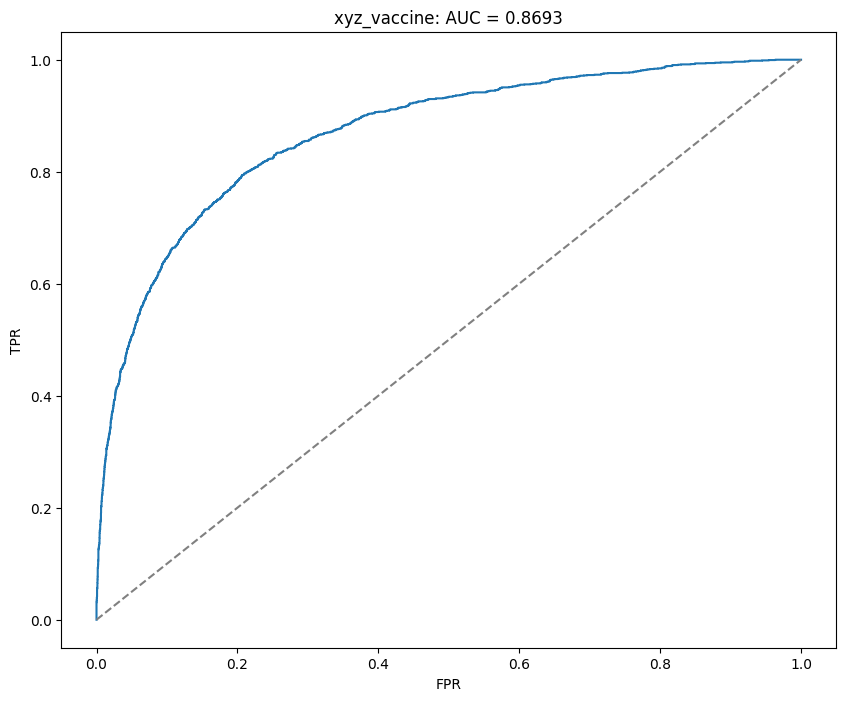

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['xyz_vaccine'],
    predictions_xyz,
    'xyz_vaccine',
    ax=ax
)

In [26]:
roc_auc_score(y_test.xyz_vaccine, predictions_xyz)

0.8693304229238155

In [27]:
train_dataset_se = Pool(data=X_train,
                     label=y_train.seasonal_vaccine,
                     cat_features = categorical_features_indices)

In [28]:
def objective2(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
         'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

    scores = cv(train_dataset_se,
            param,
            fold_count=5,
            early_stopping_rounds=10,
            plot=False, verbose=False)

    return scores['test-AUC-mean'].max()

In [29]:
sampler = optuna.samplers.TPESampler(seed=68)  # Make the sampler behave in a deterministic way.
study2 = optuna.create_study(direction="maximize", sampler=sampler)
study2.optimize(objective2, n_trials=100)

[I 2024-06-17 11:59:37,025] A new study created in memory with name: no-name-be72112a-827a-4c57-85c9-916d83c6474d
<ipython-input-28-7ef83e91da55>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),


Training on fold [0/5]

bestTest = 0.4680673689
bestIteration = 659

Training on fold [1/5]

bestTest = 0.4679162148
bestIteration = 596

Training on fold [2/5]

bestTest = 0.4548964169
bestIteration = 751

Training on fold [3/5]

bestTest = 0.4694050991
bestIteration = 624

Training on fold [4/5]


[I 2024-06-17 11:59:55,406] Trial 0 finished with value: 0.8616984834147372 and parameters: {'iterations': 1500, 'learning_rate': 0.029356482739949695, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 4, 'l2_leaf_reg': 0.001991194871120998, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8616984834147372.



bestTest = 0.4684656017
bestIteration = 630

Training on fold [0/5]

bestTest = 0.4706288193
bestIteration = 136

Training on fold [1/5]

bestTest = 0.4694001783
bestIteration = 124

Training on fold [2/5]

bestTest = 0.4553334231
bestIteration = 173

Training on fold [3/5]

bestTest = 0.4726603172
bestIteration = 121

Training on fold [4/5]


[I 2024-06-17 12:00:01,899] Trial 1 finished with value: 0.8599049374632326 and parameters: {'iterations': 200, 'learning_rate': 0.1464067066361795, 'random_strength': 10, 'bagging_temperature': 3, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 3, 'l2_leaf_reg': 0.028402775147703313, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8616984834147372.



bestTest = 0.4677509043
bestIteration = 177

Training on fold [0/5]

bestTest = 0.4719395265
bestIteration = 74

Training on fold [1/5]

bestTest = 0.4708277529
bestIteration = 73

Training on fold [2/5]

bestTest = 0.464881253
bestIteration = 57

Training on fold [3/5]

bestTest = 0.4778870243
bestIteration = 57

Training on fold [4/5]


[I 2024-06-17 12:00:08,882] Trial 2 finished with value: 0.8565182068646517 and parameters: {'iterations': 200, 'learning_rate': 0.27287829596201946, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.027330135035255495, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8616984834147372.



bestTest = 0.4749956611
bestIteration = 56

Training on fold [0/5]

bestTest = 0.4691226912
bestIteration = 514

Training on fold [1/5]

bestTest = 0.469026457
bestIteration = 560

Training on fold [2/5]

bestTest = 0.4574961435
bestIteration = 490

Training on fold [3/5]

bestTest = 0.4724478551
bestIteration = 434

Training on fold [4/5]


[I 2024-06-17 12:00:37,288] Trial 3 finished with value: 0.8601712540638478 and parameters: {'iterations': 1200, 'learning_rate': 0.0603209284932487, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 2, 'l2_leaf_reg': 1.300471404766049e-07, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8616984834147372.



bestTest = 0.4708412094
bestIteration = 399

Training on fold [0/5]

bestTest = 0.4748113
bestIteration = 76

Training on fold [1/5]

bestTest = 0.4717049779
bestIteration = 70

Training on fold [2/5]

bestTest = 0.4604737693
bestIteration = 62

Training on fold [3/5]

bestTest = 0.4692458732
bestIteration = 73

Training on fold [4/5]


[I 2024-06-17 12:00:40,178] Trial 4 finished with value: 0.8585179032630554 and parameters: {'iterations': 300, 'learning_rate': 0.22423670437233847, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 0.00010293033487726667, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8616984834147372.



bestTest = 0.4708265624
bestIteration = 70

Training on fold [0/5]

bestTest = 0.4959345563
bestIteration = 99

Training on fold [1/5]

bestTest = 0.496507013
bestIteration = 99

Training on fold [2/5]

bestTest = 0.484418213
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4962885553
bestIteration = 99

Training on fold [4/5]


[I 2024-06-17 12:00:43,771] Trial 5 finished with value: 0.8488722346645792 and parameters: {'iterations': 100, 'learning_rate': 0.06628011038512191, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 2, 'l2_leaf_reg': 13.751833235431702, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8616984834147372.



bestTest = 0.49567089
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4738227004
bestIteration = 105

Training on fold [1/5]

bestTest = 0.4718634199
bestIteration = 129

Training on fold [2/5]

bestTest = 0.4576302571
bestIteration = 124

Training on fold [3/5]

bestTest = 0.47175126
bestIteration = 121

Training on fold [4/5]


[I 2024-06-17 12:01:21,031] Trial 6 finished with value: 0.858141971134026 and parameters: {'iterations': 1200, 'learning_rate': 0.09658215406978513, 'random_strength': 8, 'bagging_temperature': 2, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 2.6558249848041764, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8616984834147372.



bestTest = 0.4720015269
bestIteration = 103

Training on fold [0/5]

bestTest = 0.4702723049
bestIteration = 137

Training on fold [1/5]

bestTest = 0.4697026234
bestIteration = 126

Training on fold [2/5]

bestTest = 0.4559212177
bestIteration = 107

Training on fold [3/5]

bestTest = 0.4704534942
bestIteration = 106

Training on fold [4/5]


[I 2024-06-17 12:01:24,804] Trial 7 finished with value: 0.860072603165318 and parameters: {'iterations': 500, 'learning_rate': 0.2714096381817127, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 4.9369231964322795, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8616984834147372.



bestTest = 0.4712145218
bestIteration = 110

Training on fold [0/5]

bestTest = 0.4727139886
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4717153772
bestIteration = 78

Training on fold [2/5]

bestTest = 0.4555618585
bestIteration = 88

Training on fold [3/5]

bestTest = 0.4717594354
bestIteration = 115

Training on fold [4/5]


[I 2024-06-17 12:01:29,597] Trial 8 finished with value: 0.8592315166646705 and parameters: {'iterations': 1500, 'learning_rate': 0.2053434310118264, 'random_strength': 8, 'bagging_temperature': 0, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 3, 'l2_leaf_reg': 9.501510078266123e-06, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8616984834147372.



bestTest = 0.4712655929
bestIteration = 100

Training on fold [0/5]

bestTest = 0.4800751169
bestIteration = 24

Training on fold [1/5]

bestTest = 0.4770321627
bestIteration = 40

Training on fold [2/5]

bestTest = 0.4637190236
bestIteration = 36

Training on fold [3/5]

bestTest = 0.4824817619
bestIteration = 43

Training on fold [4/5]


[I 2024-06-17 12:01:37,161] Trial 9 finished with value: 0.8540659416314682 and parameters: {'iterations': 100, 'learning_rate': 0.25900665720714294, 'random_strength': 3, 'bagging_temperature': 0, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 1.1694576328936887e-07, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8616984834147372.



bestTest = 0.4786436315
bestIteration = 43

Training on fold [0/5]

bestTest = 0.4769219206
bestIteration = 1422

Training on fold [1/5]

bestTest = 0.4763989445
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.4661292407
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4789353287
bestIteration = 1499

Training on fold [4/5]


[I 2024-06-17 12:02:37,474] Trial 10 finished with value: 0.8577154095345989 and parameters: {'iterations': 1500, 'learning_rate': 0.006050647464439535, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 0.007150186521078322, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8616984834147372.



bestTest = 0.4751314861
bestIteration = 1499

Training on fold [0/5]

bestTest = 0.4751881506
bestIteration = 998

Training on fold [1/5]

bestTest = 0.4760570813
bestIteration = 999

Training on fold [2/5]

bestTest = 0.4656755036
bestIteration = 999

Training on fold [3/5]

bestTest = 0.4771220413
bestIteration = 997

Training on fold [4/5]


[I 2024-06-17 12:04:13,637] Trial 11 finished with value: 0.8580785524132952 and parameters: {'iterations': 1000, 'learning_rate': 0.006258402413494596, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 5, 'l2_leaf_reg': 3.7395625169299806e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8616984834147372.



bestTest = 0.4754171225
bestIteration = 999

Training on fold [0/5]

bestTest = 0.470567975
bestIteration = 248

Training on fold [1/5]

bestTest = 0.4668895342
bestIteration = 275

Training on fold [2/5]

bestTest = 0.4568238411
bestIteration = 252

Training on fold [3/5]

bestTest = 0.4750662044
bestIteration = 213

Training on fold [4/5]


[I 2024-06-17 12:04:21,766] Trial 12 finished with value: 0.8600835174375708 and parameters: {'iterations': 1200, 'learning_rate': 0.06725819830482033, 'random_strength': 6, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 2.484887686602948e-06, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8616984834147372.



bestTest = 0.4694163548
bestIteration = 298

Training on fold [0/5]

bestTest = 0.4688322607
bestIteration = 255

Training on fold [1/5]

bestTest = 0.4692702129
bestIteration = 278

Training on fold [2/5]

bestTest = 0.4588796566
bestIteration = 172

Training on fold [3/5]

bestTest = 0.4701069669
bestIteration = 302

Training on fold [4/5]


[I 2024-06-17 12:04:36,744] Trial 13 finished with value: 0.8605097138945375 and parameters: {'iterations': 1200, 'learning_rate': 0.11844354640975294, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 2, 'l2_leaf_reg': 0.0005293545363842097, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8616984834147372.



bestTest = 0.469394244
bestIteration = 261

Training on fold [0/5]

bestTest = 0.4714416691
bestIteration = 79

Training on fold [1/5]

bestTest = 0.4753392413
bestIteration = 37

Training on fold [2/5]

bestTest = 0.4643087318
bestIteration = 62

Training on fold [3/5]

bestTest = 0.4710028481
bestIteration = 79

Training on fold [4/5]


[I 2024-06-17 12:04:47,268] Trial 14 finished with value: 0.8577117201597945 and parameters: {'iterations': 1500, 'learning_rate': 0.13150291582573478, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 0.0004751545993241495, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8616984834147372.



bestTest = 0.4723681115
bestIteration = 66

Training on fold [0/5]

bestTest = 0.4730477659
bestIteration = 74

Training on fold [1/5]

bestTest = 0.4740601615
bestIteration = 74

Training on fold [2/5]

bestTest = 0.4628170474
bestIteration = 79

Training on fold [3/5]

bestTest = 0.4754341416
bestIteration = 80

Training on fold [4/5]


[I 2024-06-17 12:05:02,258] Trial 15 finished with value: 0.8566526420551737 and parameters: {'iterations': 1000, 'learning_rate': 0.18379968329218066, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 10, 'l2_leaf_reg': 0.2794285934522289, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8616984834147372.



bestTest = 0.475428794
bestIteration = 89

Training on fold [0/5]

bestTest = 0.4714642428
bestIteration = 107

Training on fold [1/5]

bestTest = 0.4697874948
bestIteration = 92

Training on fold [2/5]

bestTest = 0.4560434339
bestIteration = 150

Training on fold [3/5]

bestTest = 0.4684215176
bestIteration = 184

Training on fold [4/5]


[I 2024-06-17 12:05:05,925] Trial 16 finished with value: 0.8603550842679712 and parameters: {'iterations': 500, 'learning_rate': 0.10406308911058082, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 6.80996375335814e-05, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8616984834147372.



bestTest = 0.4708662632
bestIteration = 100

Training on fold [0/5]

bestTest = 0.4801608154
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4801338079
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4693380921
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4810277381
bestIteration = 299

Training on fold [4/5]


[I 2024-06-17 12:05:27,336] Trial 17 finished with value: 0.8558776815108085 and parameters: {'iterations': 300, 'learning_rate': 0.035256540040725835, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 3, 'l2_leaf_reg': 0.0030542199837083703, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8616984834147372.



bestTest = 0.4798697323
bestIteration = 299

Training on fold [0/5]

bestTest = 0.4739280969
bestIteration = 123

Training on fold [1/5]

bestTest = 0.4707687521
bestIteration = 113

Training on fold [2/5]

bestTest = 0.4618030658
bestIteration = 124

Training on fold [3/5]

bestTest = 0.4743145052
bestIteration = 144

Training on fold [4/5]


[I 2024-06-17 12:05:34,446] Trial 18 finished with value: 0.8574234624213617 and parameters: {'iterations': 1500, 'learning_rate': 0.10754230079730588, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 8, 'l2_leaf_reg': 0.27380132206726326, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8616984834147372.



bestTest = 0.4749891698
bestIteration = 124

Training on fold [0/5]

bestTest = 0.4645408977
bestIteration = 517

Training on fold [1/5]

bestTest = 0.4677284181
bestIteration = 491

Training on fold [2/5]

bestTest = 0.4545610352
bestIteration = 497

Training on fold [3/5]

bestTest = 0.4669567346
bestIteration = 476

Training on fold [4/5]


[I 2024-06-17 12:06:52,233] Trial 19 finished with value: 0.8626633967843906 and parameters: {'iterations': 1200, 'learning_rate': 0.03457949514742683, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 99.11695455168572, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8626633967843906.



bestTest = 0.4628583205
bestIteration = 538

Training on fold [0/5]

bestTest = 0.464750373
bestIteration = 407

Training on fold [1/5]

bestTest = 0.4649917433
bestIteration = 408

Training on fold [2/5]

bestTest = 0.4519688763
bestIteration = 440

Training on fold [3/5]

bestTest = 0.4659789193
bestIteration = 442

Training on fold [4/5]


[I 2024-06-17 12:07:29,896] Trial 20 finished with value: 0.8632525599676019 and parameters: {'iterations': 1200, 'learning_rate': 0.04383949055596011, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 83.53611027321875, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4636557481
bestIteration = 381

Training on fold [0/5]

bestTest = 0.4665232072
bestIteration = 557

Training on fold [1/5]

bestTest = 0.4655129806
bestIteration = 469

Training on fold [2/5]

bestTest = 0.4514002906
bestIteration = 586

Training on fold [3/5]

bestTest = 0.4652078067
bestIteration = 502

Training on fold [4/5]


[I 2024-06-17 12:08:15,209] Trial 21 finished with value: 0.8629739215956157 and parameters: {'iterations': 1200, 'learning_rate': 0.035796855792548155, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 97.19978662487837, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4650348151
bestIteration = 445

Training on fold [0/5]

bestTest = 0.4659475501
bestIteration = 461

Training on fold [1/5]

bestTest = 0.4654322148
bestIteration = 454

Training on fold [2/5]

bestTest = 0.453332577
bestIteration = 452

Training on fold [3/5]

bestTest = 0.465293125
bestIteration = 502

Training on fold [4/5]


[I 2024-06-17 12:08:56,634] Trial 22 finished with value: 0.8628378238422542 and parameters: {'iterations': 1200, 'learning_rate': 0.03906848348551152, 'random_strength': 7, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 91.69888044927987, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4647162873
bestIteration = 453

Training on fold [0/5]

bestTest = 0.4681598445
bestIteration = 226

Training on fold [1/5]

bestTest = 0.4668081243
bestIteration = 228

Training on fold [2/5]

bestTest = 0.4535225026
bestIteration = 217

Training on fold [3/5]

bestTest = 0.4667508995
bestIteration = 203

Training on fold [4/5]


[I 2024-06-17 12:09:17,996] Trial 23 finished with value: 0.8620394521274941 and parameters: {'iterations': 1200, 'learning_rate': 0.0782827648920624, 'random_strength': 7, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 7, 'l2_leaf_reg': 89.94436397893038, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4650484187
bestIteration = 210

Training on fold [0/5]

bestTest = 0.4667817867
bestIteration = 317

Training on fold [1/5]

bestTest = 0.4648271243
bestIteration = 310

Training on fold [2/5]

bestTest = 0.453956542
bestIteration = 312

Training on fold [3/5]

bestTest = 0.4676048974
bestIteration = 286

Training on fold [4/5]


[I 2024-06-17 12:09:46,033] Trial 24 finished with value: 0.8626834638705498 and parameters: {'iterations': 1200, 'learning_rate': 0.04716986751290588, 'random_strength': 5, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 8, 'l2_leaf_reg': 1.174451873467657, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.463201195
bestIteration = 311

Training on fold [0/5]

bestTest = 0.4689588691
bestIteration = 165

Training on fold [1/5]

bestTest = 0.4676787566
bestIteration = 187

Training on fold [2/5]

bestTest = 0.4538879119
bestIteration = 178

Training on fold [3/5]

bestTest = 0.4667398006
bestIteration = 192

Training on fold [4/5]


[I 2024-06-17 12:10:04,044] Trial 25 finished with value: 0.8615256528790868 and parameters: {'iterations': 1200, 'learning_rate': 0.08820050826327591, 'random_strength': 6, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 24.255990500428595, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4666109165
bestIteration = 176

Training on fold [0/5]

bestTest = 0.4663795757
bestIteration = 826

Training on fold [1/5]

bestTest = 0.4656455102
bestIteration = 780

Training on fold [2/5]

bestTest = 0.4536730977
bestIteration = 830

Training on fold [3/5]

bestTest = 0.4669103814
bestIteration = 771

Training on fold [4/5]


[I 2024-06-17 12:11:15,560] Trial 26 finished with value: 0.862774084976684 and parameters: {'iterations': 1200, 'learning_rate': 0.01909271978093302, 'random_strength': 9, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 8, 'l2_leaf_reg': 0.30134826545651305, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.464197354
bestIteration = 819

Training on fold [0/5]

bestTest = 0.4679776481
bestIteration = 88

Training on fold [1/5]

bestTest = 0.4702127789
bestIteration = 85

Training on fold [2/5]

bestTest = 0.4558507716
bestIteration = 88

Training on fold [3/5]

bestTest = 0.4698848341
bestIteration = 98

Training on fold [4/5]


[I 2024-06-17 12:11:25,056] Trial 27 finished with value: 0.8610812499875926 and parameters: {'iterations': 1200, 'learning_rate': 0.16757078202372552, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 14.627476007357282, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4656539522
bestIteration = 87

Training on fold [0/5]

bestTest = 0.4658019653
bestIteration = 337

Training on fold [1/5]

bestTest = 0.4663126191
bestIteration = 359

Training on fold [2/5]

bestTest = 0.4533529348
bestIteration = 300

Training on fold [3/5]

bestTest = 0.4690723413
bestIteration = 305

Training on fold [4/5]


[I 2024-06-17 12:11:53,750] Trial 28 finished with value: 0.8621673389399487 and parameters: {'iterations': 1200, 'learning_rate': 0.0501800859713282, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 0.8258715838513688, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4650606147
bestIteration = 288

Training on fold [0/5]

bestTest = 0.4648221966
bestIteration = 695

Training on fold [1/5]

bestTest = 0.4662017997
bestIteration = 598

Training on fold [2/5]

bestTest = 0.4537454793
bestIteration = 690

Training on fold [3/5]

bestTest = 0.4662875523
bestIteration = 704

Training on fold [4/5]


[I 2024-06-17 12:12:56,753] Trial 29 finished with value: 0.8627569051165602 and parameters: {'iterations': 1000, 'learning_rate': 0.02365573498094517, 'random_strength': 5, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 9, 'l2_leaf_reg': 94.78409012636061, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4648213241
bestIteration = 623

Training on fold [0/5]

bestTest = 0.6600592101
bestIteration = 99

Training on fold [1/5]

bestTest = 0.6603474489
bestIteration = 99

Training on fold [2/5]

bestTest = 0.6599570799
bestIteration = 99

Training on fold [3/5]

bestTest = 0.6596536807
bestIteration = 99

Training on fold [4/5]


[I 2024-06-17 12:13:13,152] Trial 30 finished with value: 0.8298490195150713 and parameters: {'iterations': 100, 'learning_rate': 0.0016582559283094406, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 7, 'l2_leaf_reg': 6.705172120716611, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.6599797046
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4661458867
bestIteration = 760

Training on fold [1/5]

bestTest = 0.4659033187
bestIteration = 712

Training on fold [2/5]

bestTest = 0.4532773951
bestIteration = 721

Training on fold [3/5]

bestTest = 0.4694459129
bestIteration = 709

Training on fold [4/5]


[I 2024-06-17 12:14:17,153] Trial 31 finished with value: 0.8620713999090783 and parameters: {'iterations': 1200, 'learning_rate': 0.02134781583625273, 'random_strength': 9, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 8, 'l2_leaf_reg': 0.06917453193989952, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.467003024
bestIteration = 668

Training on fold [0/5]

bestTest = 0.4807990473
bestIteration = 199

Training on fold [1/5]

bestTest = 0.478763375
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4708010729
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4805752757
bestIteration = 199

Training on fold [4/5]


[I 2024-06-17 12:14:34,345] Trial 32 finished with value: 0.8563064182489175 and parameters: {'iterations': 200, 'learning_rate': 0.04303768608139345, 'random_strength': 9, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 20.814683046754386, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4776949196
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4665752584
bestIteration = 654

Training on fold [1/5]

bestTest = 0.4680026848
bestIteration = 629

Training on fold [2/5]

bestTest = 0.4530817319
bestIteration = 717

Training on fold [3/5]

bestTest = 0.467512863
bestIteration = 646

Training on fold [4/5]


[I 2024-06-17 12:15:31,042] Trial 33 finished with value: 0.8624696579386721 and parameters: {'iterations': 1200, 'learning_rate': 0.022724123291912264, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 6, 'l2_leaf_reg': 0.2468021342200819, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4643046731
bestIteration = 620

Training on fold [0/5]

bestTest = 0.4685279979
bestIteration = 222

Training on fold [1/5]

bestTest = 0.4681775144
bestIteration = 195

Training on fold [2/5]

bestTest = 0.4563205158
bestIteration = 201

Training on fold [3/5]

bestTest = 0.4657748512
bestIteration = 233

Training on fold [4/5]


[I 2024-06-17 12:15:51,557] Trial 34 finished with value: 0.8611599104613514 and parameters: {'iterations': 1200, 'learning_rate': 0.07362600388003086, 'random_strength': 8, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 1.5213479689378886, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4668224304
bestIteration = 190

Training on fold [0/5]

bestTest = 0.4717797915
bestIteration = 198

Training on fold [1/5]

bestTest = 0.4755409514
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4605787295
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4731543138
bestIteration = 199

Training on fold [4/5]


[I 2024-06-17 12:16:23,369] Trial 35 finished with value: 0.8585478058365885 and parameters: {'iterations': 200, 'learning_rate': 0.05630398926399551, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 9, 'l2_leaf_reg': 0.05149255088480003, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4738890554
bestIteration = 199

Training on fold [0/5]

bestTest = 0.470831977
bestIteration = 111

Training on fold [1/5]

bestTest = 0.4689786014
bestIteration = 117

Training on fold [2/5]

bestTest = 0.4556380087
bestIteration = 123

Training on fold [3/5]

bestTest = 0.4709087059
bestIteration = 112

Training on fold [4/5]


[I 2024-06-17 12:16:34,924] Trial 36 finished with value: 0.8601528055685879 and parameters: {'iterations': 300, 'learning_rate': 0.1390352277583939, 'random_strength': 7, 'bagging_temperature': 7, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 7, 'l2_leaf_reg': 28.393006262422, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4672997951
bestIteration = 105

Training on fold [0/5]

bestTest = 0.4655281536
bestIteration = 188

Training on fold [1/5]

bestTest = 0.4673314809
bestIteration = 174

Training on fold [2/5]

bestTest = 0.455944226
bestIteration = 192

Training on fold [3/5]

bestTest = 0.467269816
bestIteration = 187

Training on fold [4/5]


[I 2024-06-17 12:16:45,698] Trial 37 finished with value: 0.861979862472712 and parameters: {'iterations': 1200, 'learning_rate': 0.08373889814490736, 'random_strength': 9, 'bagging_temperature': 4, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 4.656699410799948, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4656011081
bestIteration = 188

Training on fold [0/5]

bestTest = 0.4796996521
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4801301951
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4702441173
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4803561222
bestIteration = 499

Training on fold [4/5]


[I 2024-06-17 12:17:28,138] Trial 38 finished with value: 0.8567347838228259 and parameters: {'iterations': 500, 'learning_rate': 0.016507716254390004, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 9, 'l2_leaf_reg': 38.006536591311196, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4778476593
bestIteration = 499

Training on fold [0/5]

bestTest = 0.46881849
bestIteration = 239

Training on fold [1/5]

bestTest = 0.4730559365
bestIteration = 209

Training on fold [2/5]

bestTest = 0.4574307494
bestIteration = 240

Training on fold [3/5]

bestTest = 0.4708530758
bestIteration = 215

Training on fold [4/5]


[I 2024-06-17 12:17:45,188] Trial 39 finished with value: 0.8599415720117444 and parameters: {'iterations': 1200, 'learning_rate': 0.05777425466782243, 'random_strength': 7, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 6, 'l2_leaf_reg': 0.015190887939439747, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4666557286
bestIteration = 239

Training on fold [0/5]

bestTest = 0.4669718986
bestIteration = 458

Training on fold [1/5]

bestTest = 0.4657397205
bestIteration = 512

Training on fold [2/5]

bestTest = 0.4526414677
bestIteration = 476

Training on fold [3/5]

bestTest = 0.4670022194
bestIteration = 483

Training on fold [4/5]


[I 2024-06-17 12:18:28,687] Trial 40 finished with value: 0.862571035262915 and parameters: {'iterations': 1200, 'learning_rate': 0.032431375309720206, 'random_strength': 8, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 7, 'l2_leaf_reg': 6.906945716480768, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4647001942
bestIteration = 436

Training on fold [0/5]

bestTest = 0.4657592568
bestIteration = 898

Training on fold [1/5]

bestTest = 0.4666134067
bestIteration = 875

Training on fold [2/5]

bestTest = 0.4529806653
bestIteration = 950

Training on fold [3/5]

bestTest = 0.4654028227
bestIteration = 973

Training on fold [4/5]


[I 2024-06-17 12:19:55,786] Trial 41 finished with value: 0.8630397364727557 and parameters: {'iterations': 1000, 'learning_rate': 0.016200486507274122, 'random_strength': 5, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 9, 'l2_leaf_reg': 72.32590011902855, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4639680182
bestIteration = 965

Training on fold [0/5]

bestTest = 0.4659077719
bestIteration = 998

Training on fold [1/5]

bestTest = 0.4659911598
bestIteration = 999

Training on fold [2/5]

bestTest = 0.453900959
bestIteration = 999

Training on fold [3/5]

bestTest = 0.467879615
bestIteration = 977

Training on fold [4/5]


[I 2024-06-17 12:21:24,007] Trial 42 finished with value: 0.862553925810834 and parameters: {'iterations': 1000, 'learning_rate': 0.013749492590192113, 'random_strength': 5, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 9, 'l2_leaf_reg': 35.911057856613866, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4660718195
bestIteration = 932

Training on fold [0/5]

bestTest = 0.4662629578
bestIteration = 374

Training on fold [1/5]

bestTest = 0.4666970027
bestIteration = 368

Training on fold [2/5]

bestTest = 0.455398245
bestIteration = 330

Training on fold [3/5]

bestTest = 0.4669605179
bestIteration = 337

Training on fold [4/5]


[I 2024-06-17 12:21:56,279] Trial 43 finished with value: 0.86225190981815 and parameters: {'iterations': 1000, 'learning_rate': 0.040054666559269377, 'random_strength': 4, 'bagging_temperature': 1, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 10, 'l2_leaf_reg': 2.943920816556651, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4641114698
bestIteration = 358

Training on fold [0/5]

bestTest = 0.4704493672
bestIteration = 60

Training on fold [1/5]

bestTest = 0.4703045597
bestIteration = 53

Training on fold [2/5]

bestTest = 0.4548605549
bestIteration = 58

Training on fold [3/5]

bestTest = 0.4710585126
bestIteration = 67

Training on fold [4/5]


[I 2024-06-17 12:22:03,671] Trial 44 finished with value: 0.8596446592455884 and parameters: {'iterations': 100, 'learning_rate': 0.2473573933077939, 'random_strength': 4, 'bagging_temperature': 1, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 10.864114722691193, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4683371844
bestIteration = 52

Training on fold [0/5]

bestTest = 0.4706782328
bestIteration = 63

Training on fold [1/5]

bestTest = 0.4711438016
bestIteration = 72

Training on fold [2/5]

bestTest = 0.4617142799
bestIteration = 59

Training on fold [3/5]

bestTest = 0.469115785
bestIteration = 108

Training on fold [4/5]


[I 2024-06-17 12:22:17,875] Trial 45 finished with value: 0.8592628629339375 and parameters: {'iterations': 1000, 'learning_rate': 0.29311363349234243, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 6, 'l2_leaf_reg': 97.75269044167258, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4656628222
bestIteration = 52

Training on fold [0/5]

bestTest = 0.4698633317
bestIteration = 196

Training on fold [1/5]

bestTest = 0.4702885821
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4583710751
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4697163674
bestIteration = 199

Training on fold [4/5]


[I 2024-06-17 12:22:29,354] Trial 46 finished with value: 0.8604489743520178 and parameters: {'iterations': 200, 'learning_rate': 0.06312065407316633, 'random_strength': 6, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 5, 'l2_leaf_reg': 2.2191599708738536, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4677518428
bestIteration = 199

Training on fold [0/5]

bestTest = 0.5252317672
bestIteration = 299

Training on fold [1/5]

bestTest = 0.527144486
bestIteration = 299

Training on fold [2/5]

bestTest = 0.5219673112
bestIteration = 299

Training on fold [3/5]

bestTest = 0.526892532
bestIteration = 299

Training on fold [4/5]


[I 2024-06-17 12:23:17,175] Trial 47 finished with value: 0.8449098669195356 and parameters: {'iterations': 300, 'learning_rate': 0.00500476971142047, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 7, 'l2_leaf_reg': 0.5701718141818125, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.5251823712
bestIteration = 299

Training on fold [0/5]

bestTest = 0.4714332048
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4710056085
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4590261454
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4720918694
bestIteration = 499

Training on fold [4/5]


[I 2024-06-17 12:23:49,786] Trial 48 finished with value: 0.860155326560309 and parameters: {'iterations': 500, 'learning_rate': 0.02529152251563399, 'random_strength': 7, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 4, 'l2_leaf_reg': 43.47420418611471, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4703654883
bestIteration = 499

Training on fold [0/5]

bestTest = 0.4659089984
bestIteration = 315

Training on fold [1/5]

bestTest = 0.4670950264
bestIteration = 306

Training on fold [2/5]

bestTest = 0.4528226904
bestIteration = 305

Training on fold [3/5]

bestTest = 0.46687779
bestIteration = 329

Training on fold [4/5]


[I 2024-06-17 12:24:15,776] Trial 49 finished with value: 0.8627356792423988 and parameters: {'iterations': 1200, 'learning_rate': 0.048738035958499876, 'random_strength': 5, 'bagging_temperature': 4, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 5, 'l2_leaf_reg': 6.971776309479283, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4637464792
bestIteration = 300

Training on fold [0/5]

bestTest = 0.4805582052
bestIteration = 119

Training on fold [1/5]

bestTest = 0.4830725262
bestIteration = 59

Training on fold [2/5]

bestTest = 0.4717840624
bestIteration = 82

Training on fold [3/5]

bestTest = 0.4866973995
bestIteration = 94

Training on fold [4/5]


[I 2024-06-17 12:24:28,949] Trial 50 finished with value: 0.8517413061949151 and parameters: {'iterations': 1000, 'learning_rate': 0.09290502364200545, 'random_strength': 10, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 9, 'l2_leaf_reg': 0.1097083383005771, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4765193733
bestIteration = 102

Training on fold [0/5]

bestTest = 0.4650720744
bestIteration = 990

Training on fold [1/5]

bestTest = 0.4642739529
bestIteration = 965

Training on fold [2/5]

bestTest = 0.4530628847
bestIteration = 920

Training on fold [3/5]

bestTest = 0.4670386227
bestIteration = 841

Training on fold [4/5]


[I 2024-06-17 12:25:55,079] Trial 51 finished with value: 0.8631322393396996 and parameters: {'iterations': 1000, 'learning_rate': 0.016727749211489753, 'random_strength': 5, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 10, 'l2_leaf_reg': 82.29241696702528, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4641948473
bestIteration = 874

Training on fold [0/5]

bestTest = 0.4652495656
bestIteration = 972

Training on fold [1/5]

bestTest = 0.4648774974
bestIteration = 981

Training on fold [2/5]

bestTest = 0.4541433453
bestIteration = 980

Training on fold [3/5]

bestTest = 0.4660807973
bestIteration = 971

Training on fold [4/5]


[I 2024-06-17 12:27:25,509] Trial 52 finished with value: 0.863205457582794 and parameters: {'iterations': 1000, 'learning_rate': 0.013749050611953313, 'random_strength': 3, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 10, 'l2_leaf_reg': 12.662628542737309, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4630879319
bestIteration = 982

Training on fold [0/5]

bestTest = 0.4660377014
bestIteration = 999

Training on fold [1/5]

bestTest = 0.4669480599
bestIteration = 999

Training on fold [2/5]

bestTest = 0.4544716338
bestIteration = 998

Training on fold [3/5]

bestTest = 0.4673240424
bestIteration = 998

Training on fold [4/5]


[I 2024-06-17 12:28:57,715] Trial 53 finished with value: 0.8626523822269985 and parameters: {'iterations': 1000, 'learning_rate': 0.011911521607058911, 'random_strength': 2, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 10, 'l2_leaf_reg': 46.40707285502377, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4640796937
bestIteration = 990

Training on fold [0/5]

bestTest = 0.4661974571
bestIteration = 309

Training on fold [1/5]

bestTest = 0.4646729373
bestIteration = 405

Training on fold [2/5]

bestTest = 0.4535450694
bestIteration = 346

Training on fold [3/5]

bestTest = 0.4679846892
bestIteration = 382

Training on fold [4/5]


[I 2024-06-17 12:29:33,229] Trial 54 finished with value: 0.8626422858857683 and parameters: {'iterations': 1000, 'learning_rate': 0.037069902022496326, 'random_strength': 2, 'bagging_temperature': 3, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 10, 'l2_leaf_reg': 17.419419437760258, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4634981884
bestIteration = 372

Training on fold [0/5]

bestTest = 0.4646833159
bestIteration = 222

Training on fold [1/5]

bestTest = 0.4665258714
bestIteration = 209

Training on fold [2/5]

bestTest = 0.4540372613
bestIteration = 216

Training on fold [3/5]

bestTest = 0.4665955194
bestIteration = 230

Training on fold [4/5]


[I 2024-06-17 12:29:53,384] Trial 55 finished with value: 0.8624494933466386 and parameters: {'iterations': 1000, 'learning_rate': 0.06596360002106631, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 10, 'l2_leaf_reg': 14.97072779769684, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4653004868
bestIteration = 200

Training on fold [0/5]

bestTest = 0.4644001033
bestIteration = 446

Training on fold [1/5]

bestTest = 0.4668351349
bestIteration = 424

Training on fold [2/5]

bestTest = 0.4553517135
bestIteration = 449

Training on fold [3/5]

bestTest = 0.4668432572
bestIteration = 431

Training on fold [4/5]


[I 2024-06-17 12:31:14,035] Trial 56 finished with value: 0.8625405642635512 and parameters: {'iterations': 1000, 'learning_rate': 0.03170778190994155, 'random_strength': 3, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 10, 'l2_leaf_reg': 51.40869534050837, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4662678507
bestIteration = 433

Training on fold [0/5]

bestTest = 0.4766333423
bestIteration = 98

Training on fold [1/5]

bestTest = 0.474998998
bestIteration = 106

Training on fold [2/5]

bestTest = 0.4667613763
bestIteration = 104

Training on fold [3/5]

bestTest = 0.477755283
bestIteration = 106

Training on fold [4/5]


[I 2024-06-17 12:31:23,928] Trial 57 finished with value: 0.855720470774376 and parameters: {'iterations': 1000, 'learning_rate': 0.12090670526107813, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 9.985357667065326e-07, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4744705167
bestIteration = 106

Training on fold [0/5]

bestTest = 0.4676049279
bestIteration = 81

Training on fold [1/5]

bestTest = 0.4751578745
bestIteration = 70

Training on fold [2/5]

bestTest = 0.4586558056
bestIteration = 70

Training on fold [3/5]

bestTest = 0.4728129047
bestIteration = 62

Training on fold [4/5]


[I 2024-06-17 12:31:37,609] Trial 58 finished with value: 0.858545327361002 and parameters: {'iterations': 1500, 'learning_rate': 0.21001844565389935, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 10, 'l2_leaf_reg': 2.9639519304130832, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4700167028
bestIteration = 65

Training on fold [0/5]

bestTest = 0.4799549787
bestIteration = 82

Training on fold [1/5]

bestTest = 0.4796321493
bestIteration = 80

Training on fold [2/5]

bestTest = 0.4701053618
bestIteration = 74

Training on fold [3/5]

bestTest = 0.4802552295
bestIteration = 77

Training on fold [4/5]


[I 2024-06-17 12:31:45,986] Trial 59 finished with value: 0.8538422455864282 and parameters: {'iterations': 1000, 'learning_rate': 0.15451251756405535, 'random_strength': 7, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 3.583682147349126e-05, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4784383699
bestIteration = 77

Training on fold [0/5]

bestTest = 0.4668226125
bestIteration = 183

Training on fold [1/5]

bestTest = 0.4543629848
bestIteration = 201

Training on fold [3/5]

bestTest = 0.4687632886
bestIteration = 180

Training on fold [4/5]


[I 2024-06-17 12:31:54,754] Trial 60 finished with value: 0.8618602919154496 and parameters: {'iterations': 1000, 'learning_rate': 0.07369585090354537, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 7, 'l2_leaf_reg': 10.203906911850048, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4652592351
bestIteration = 183

Training on fold [0/5]

bestTest = 0.4664766181
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.4658809984
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.453934363
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.4673405747
bestIteration = 1195

Training on fold [4/5]


[I 2024-06-17 12:33:41,053] Trial 61 finished with value: 0.8627814185301528 and parameters: {'iterations': 1200, 'learning_rate': 0.012217554292261214, 'random_strength': 8, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 9, 'l2_leaf_reg': 66.33951327719123, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4645046414
bestIteration = 1195

Training on fold [0/5]

bestTest = 0.4682517824
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.4674282578
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.4560530708
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.4676142321
bestIteration = 1199

Training on fold [4/5]


[I 2024-06-17 12:35:25,928] Trial 62 finished with value: 0.8620527058790053 and parameters: {'iterations': 1200, 'learning_rate': 0.011437578680877046, 'random_strength': 8, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 9, 'l2_leaf_reg': 91.0106309056333, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4659390837
bestIteration = 1199

Training on fold [0/5]

bestTest = 0.5115719792
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.5100551575
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.5045827427
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.51128623
bestIteration = 1199

Training on fold [4/5]


[I 2024-06-17 12:37:05,254] Trial 63 finished with value: 0.8457250582156723 and parameters: {'iterations': 1200, 'learning_rate': 0.002722932777361414, 'random_strength': 8, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 10, 'l2_leaf_reg': 54.03919158302362, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.5101519764
bestIteration = 1199

Training on fold [0/5]

bestTest = 0.4977364015
bestIteration = 98

Training on fold [1/5]

bestTest = 0.4948761399
bestIteration = 99

Training on fold [2/5]

bestTest = 0.483274459
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4951086217
bestIteration = 99

Training on fold [4/5]


[I 2024-06-17 12:37:13,651] Trial 64 finished with value: 0.8505635931857721 and parameters: {'iterations': 100, 'learning_rate': 0.04745666250896635, 'random_strength': 7, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 9, 'l2_leaf_reg': 21.0588977551466, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4954105681
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4655419389
bestIteration = 518

Training on fold [1/5]

bestTest = 0.4673842483
bestIteration = 545

Training on fold [2/5]

bestTest = 0.453767055
bestIteration = 591

Training on fold [3/5]

bestTest = 0.4674352738
bestIteration = 524

Training on fold [4/5]


[I 2024-06-17 12:38:42,749] Trial 65 finished with value: 0.8624663940560788 and parameters: {'iterations': 1200, 'learning_rate': 0.027413738003557137, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 4.038519655269663, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4636283686
bestIteration = 530

Training on fold [0/5]

bestTest = 0.4680675432
bestIteration = 377

Training on fold [1/5]

bestTest = 0.4666782272
bestIteration = 380

Training on fold [2/5]

bestTest = 0.4540820669
bestIteration = 434

Training on fold [3/5]

bestTest = 0.4675236306
bestIteration = 364

Training on fold [4/5]


[I 2024-06-17 12:39:19,867] Trial 66 finished with value: 0.8624844071000954 and parameters: {'iterations': 1500, 'learning_rate': 0.040198772212990855, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 53.14389234813218, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4638928739
bestIteration = 389

Training on fold [0/5]

bestTest = 0.4680401047
bestIteration = 234

Training on fold [1/5]

bestTest = 0.4664766056
bestIteration = 272

Training on fold [2/5]

bestTest = 0.4541745449
bestIteration = 290

Training on fold [3/5]

bestTest = 0.4660370471
bestIteration = 248

Training on fold [4/5]


[I 2024-06-17 12:39:42,685] Trial 67 finished with value: 0.8623634611045194 and parameters: {'iterations': 500, 'learning_rate': 0.05560662618320142, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 9.608525504598905, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.463123579
bestIteration = 286

Training on fold [0/5]

bestTest = 0.4825583729
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4797398354
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4730121382
bestIteration = 299

Training on fold [3/5]

bestTest = 0.482775407
bestIteration = 299

Training on fold [4/5]


[I 2024-06-17 12:39:59,180] Trial 68 finished with value: 0.8562371245262842 and parameters: {'iterations': 300, 'learning_rate': 0.016876558894264163, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 9, 'l2_leaf_reg': 23.743507006641806, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4802329724
bestIteration = 298

Training on fold [0/5]

bestTest = 0.470148272
bestIteration = 423

Training on fold [1/5]

bestTest = 0.4676157401
bestIteration = 469

Training on fold [2/5]

bestTest = 0.4537736159
bestIteration = 485

Training on fold [3/5]

bestTest = 0.4720360038
bestIteration = 439

Training on fold [4/5]


[I 2024-06-17 12:41:14,618] Trial 69 finished with value: 0.8609843344090852 and parameters: {'iterations': 1200, 'learning_rate': 0.028990926499962322, 'random_strength': 5, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 8, 'l2_leaf_reg': 1.6153613717978845e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4655673795
bestIteration = 457

Training on fold [0/5]

bestTest = 0.5012152085
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.5002382546
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.4942371927
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.5008228413
bestIteration = 1199

Training on fold [4/5]


[I 2024-06-17 12:42:56,850] Trial 70 finished with value: 0.851315085816419 and parameters: {'iterations': 1200, 'learning_rate': 0.0023300141876089475, 'random_strength': 8, 'bagging_temperature': 5, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 7, 'l2_leaf_reg': 1.5919673230478422, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4993119383
bestIteration = 1199

Training on fold [0/5]

bestTest = 0.465801859
bestIteration = 747

Training on fold [1/5]

bestTest = 0.4655102854
bestIteration = 708

Training on fold [2/5]

bestTest = 0.4534267414
bestIteration = 715

Training on fold [3/5]

bestTest = 0.4653972796
bestIteration = 699

Training on fold [4/5]


[I 2024-06-17 12:44:03,037] Trial 71 finished with value: 0.8630718537233216 and parameters: {'iterations': 1200, 'learning_rate': 0.02383527818260917, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 8, 'l2_leaf_reg': 96.85828122265345, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4634718356
bestIteration = 697

Training on fold [0/5]

bestTest = 0.4662945435
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.4663600896
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.4537265705
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.4674812605
bestIteration = 1199

Training on fold [4/5]


[I 2024-06-17 12:45:50,088] Trial 72 finished with value: 0.8626378412457459 and parameters: {'iterations': 1200, 'learning_rate': 0.012341118467627062, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 9, 'l2_leaf_reg': 95.62836167976089, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4652984337
bestIteration = 1199

Training on fold [0/5]

bestTest = 0.467680812
bestIteration = 374

Training on fold [1/5]

bestTest = 0.4671412875
bestIteration = 390

Training on fold [2/5]

bestTest = 0.4528055329
bestIteration = 388

Training on fold [3/5]

bestTest = 0.4661986415
bestIteration = 378

Training on fold [4/5]


[I 2024-06-17 12:46:24,315] Trial 73 finished with value: 0.8624220342101031 and parameters: {'iterations': 1200, 'learning_rate': 0.040893324883144795, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 10, 'l2_leaf_reg': 27.808707990697524, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4638890632
bestIteration = 371

Training on fold [0/5]

bestTest = 0.4661804094
bestIteration = 649

Training on fold [1/5]

bestTest = 0.466165316
bestIteration = 788

Training on fold [2/5]

bestTest = 0.4536110329
bestIteration = 767

Training on fold [3/5]

bestTest = 0.4657708959
bestIteration = 795

Training on fold [4/5]


[I 2024-06-17 12:47:29,453] Trial 74 finished with value: 0.8628267630630411 and parameters: {'iterations': 1200, 'learning_rate': 0.022705855786612578, 'random_strength': 10, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 6, 'l2_leaf_reg': 54.468426387217605, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4641291597
bestIteration = 705

Training on fold [0/5]

bestTest = 0.4975082951
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4960152524
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4883416889
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4966007783
bestIteration = 199

Training on fold [4/5]


[I 2024-06-17 12:47:47,528] Trial 75 finished with value: 0.8506568632621555 and parameters: {'iterations': 200, 'learning_rate': 0.023058063312917078, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 6, 'l2_leaf_reg': 13.509760359061719, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4951682912
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4656905196
bestIteration = 296

Training on fold [1/5]

bestTest = 0.4671306628
bestIteration = 300

Training on fold [2/5]

bestTest = 0.4531934974
bestIteration = 327

Training on fold [3/5]

bestTest = 0.4664360742
bestIteration = 348

Training on fold [4/5]


[I 2024-06-17 12:48:16,185] Trial 76 finished with value: 0.8626914247107085 and parameters: {'iterations': 1200, 'learning_rate': 0.05289994192729316, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 6, 'l2_leaf_reg': 32.7805922522276, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4635085981
bestIteration = 331

Training on fold [0/5]

bestTest = 0.4657861959
bestIteration = 430

Training on fold [1/5]

bestTest = 0.467415726
bestIteration = 439

Training on fold [2/5]

bestTest = 0.4548331992
bestIteration = 446

Training on fold [3/5]

bestTest = 0.4663235007
bestIteration = 421

Training on fold [4/5]


[I 2024-06-17 12:49:32,322] Trial 77 finished with value: 0.8624261421951296 and parameters: {'iterations': 1000, 'learning_rate': 0.03575566412079577, 'random_strength': 10, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 6, 'l2_leaf_reg': 5.368301708258678, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4639964586
bestIteration = 480

Training on fold [0/5]

bestTest = 0.4649451632
bestIteration = 540

Training on fold [1/5]

bestTest = 0.4666680205
bestIteration = 516

Training on fold [2/5]

bestTest = 0.4549050071
bestIteration = 549

Training on fold [3/5]

bestTest = 0.4664398742
bestIteration = 614

Training on fold [4/5]


[I 2024-06-17 12:50:15,813] Trial 78 finished with value: 0.8628254296776516 and parameters: {'iterations': 1200, 'learning_rate': 0.027342435084526308, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 22.51094017672503, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4657437378
bestIteration = 481

Training on fold [0/5]

bestTest = 0.5307571589
bestIteration = 99

Training on fold [1/5]

bestTest = 0.5334823235
bestIteration = 99

Training on fold [2/5]

bestTest = 0.5277992304
bestIteration = 99

Training on fold [3/5]

bestTest = 0.5328766776
bestIteration = 99

Training on fold [4/5]


[I 2024-06-17 12:50:25,175] Trial 79 finished with value: 0.8398948840682612 and parameters: {'iterations': 100, 'learning_rate': 0.01902048577472067, 'random_strength': 9, 'bagging_temperature': 2, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 0.0024181420745483934, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.5313161188
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4641774583
bestIteration = 371

Training on fold [1/5]

bestTest = 0.4664905647
bestIteration = 355

Training on fold [2/5]

bestTest = 0.4538853997
bestIteration = 325

Training on fold [3/5]

bestTest = 0.4655875861
bestIteration = 331

Training on fold [4/5]


[I 2024-06-17 12:51:21,328] Trial 80 finished with value: 0.8632069118000306 and parameters: {'iterations': 1000, 'learning_rate': 0.048748306411023984, 'random_strength': 5, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 50.642834829510605, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4620938315
bestIteration = 435

Training on fold [0/5]

bestTest = 0.4666928702
bestIteration = 506

Training on fold [1/5]

bestTest = 0.4691247277
bestIteration = 402

Training on fold [2/5]

bestTest = 0.4547781562
bestIteration = 467

Training on fold [3/5]

bestTest = 0.4685459568
bestIteration = 513

Training on fold [4/5]


[I 2024-06-17 12:52:11,854] Trial 81 finished with value: 0.8618938114374689 and parameters: {'iterations': 1000, 'learning_rate': 0.04443703175214092, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 3, 'l2_leaf_reg': 52.486148193433166, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4649723993
bestIteration = 417

Training on fold [0/5]

bestTest = 0.4655524387
bestIteration = 423

Training on fold [1/5]

bestTest = 0.4689637063
bestIteration = 426

Training on fold [2/5]

bestTest = 0.4567357866
bestIteration = 419

Training on fold [3/5]

bestTest = 0.4697883213
bestIteration = 457

Training on fold [4/5]


[I 2024-06-17 12:53:18,706] Trial 82 finished with value: 0.8613319874853674 and parameters: {'iterations': 1000, 'learning_rate': 0.03315730486412741, 'random_strength': 6, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.0008889236391223016, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4659699997
bestIteration = 438

Training on fold [0/5]

bestTest = 0.4659081742
bestIteration = 258

Training on fold [1/5]

bestTest = 0.4684086208
bestIteration = 238

Training on fold [2/5]

bestTest = 0.4546212698
bestIteration = 270

Training on fold [3/5]

bestTest = 0.4666164897
bestIteration = 373

Training on fold [4/5]


[I 2024-06-17 12:53:56,585] Trial 83 finished with value: 0.8622275479075775 and parameters: {'iterations': 1000, 'learning_rate': 0.07132617685682549, 'random_strength': 5, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 4, 'l2_leaf_reg': 95.19687633935044, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4635716726
bestIteration = 305

Training on fold [0/5]

bestTest = 0.4644653104
bestIteration = 339

Training on fold [1/5]

bestTest = 0.465864391
bestIteration = 303

Training on fold [2/5]

bestTest = 0.454201042
bestIteration = 272

Training on fold [3/5]

bestTest = 0.4665107524
bestIteration = 290

Training on fold [4/5]


[I 2024-06-17 12:54:35,708] Trial 84 finished with value: 0.862617704744139 and parameters: {'iterations': 1000, 'learning_rate': 0.06224641174895647, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 4, 'l2_leaf_reg': 8.23742158754364, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4653337677
bestIteration = 270

Training on fold [0/5]

bestTest = 0.4710413445
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.4703755487
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.459610855
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.4715693147
bestIteration = 1199

Training on fold [4/5]


[I 2024-06-17 12:56:11,777] Trial 85 finished with value: 0.8605934996635105 and parameters: {'iterations': 1200, 'learning_rate': 0.009049981305863465, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 33.4828326241028, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4690163616
bestIteration = 1199

Training on fold [0/5]

bestTest = 0.4655090324
bestIteration = 226

Training on fold [1/5]

bestTest = 0.4648527865
bestIteration = 209

Training on fold [2/5]

bestTest = 0.4554826855
bestIteration = 225

Training on fold [3/5]

bestTest = 0.4689372796
bestIteration = 214

Training on fold [4/5]


[I 2024-06-17 12:56:21,711] Trial 86 finished with value: 0.8624262392047066 and parameters: {'iterations': 300, 'learning_rate': 0.05084808763140622, 'random_strength': 1, 'bagging_temperature': 1, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 7, 'l2_leaf_reg': 13.89911751986566, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4646923127
bestIteration = 227

Training on fold [0/5]

bestTest = 0.4654401234
bestIteration = 801

Training on fold [1/5]

bestTest = 0.4656439056
bestIteration = 803

Training on fold [2/5]

bestTest = 0.4542942859
bestIteration = 758

Training on fold [3/5]

bestTest = 0.4655339369
bestIteration = 892

Training on fold [4/5]


[I 2024-06-17 12:57:11,960] Trial 87 finished with value: 0.8629334013370912 and parameters: {'iterations': 1000, 'learning_rate': 0.020055496077333777, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 66.56355085388805, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4643433505
bestIteration = 701

Training on fold [0/5]

bestTest = 0.4672872573
bestIteration = 750

Training on fold [1/5]

bestTest = 0.4644850459
bestIteration = 739

Training on fold [2/5]

bestTest = 0.4523988435
bestIteration = 813

Training on fold [3/5]

bestTest = 0.4665274569
bestIteration = 731

Training on fold [4/5]


[I 2024-06-17 12:58:25,703] Trial 88 finished with value: 0.8630314598551738 and parameters: {'iterations': 1000, 'learning_rate': 0.018253539683087346, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 30.64297447176037, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4636002569
bestIteration = 689

Training on fold [0/5]

bestTest = 0.5015772114
bestIteration = 999

Training on fold [1/5]

bestTest = 0.5016802999
bestIteration = 999

Training on fold [2/5]

bestTest = 0.495675218
bestIteration = 999

Training on fold [3/5]

bestTest = 0.5020835202
bestIteration = 999

Training on fold [4/5]


[I 2024-06-17 13:00:13,015] Trial 89 finished with value: 0.8515664957308507 and parameters: {'iterations': 1000, 'learning_rate': 0.00236706344782198, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 4.470884957594793, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.5006059047
bestIteration = 999

Training on fold [0/5]

bestTest = 0.4661392756
bestIteration = 731

Training on fold [1/5]

bestTest = 0.4703175437
bestIteration = 516

Training on fold [2/5]

bestTest = 0.4545330532
bestIteration = 699

Training on fold [3/5]

bestTest = 0.4685150268
bestIteration = 739

Training on fold [4/5]


[I 2024-06-17 13:01:20,564] Trial 90 finished with value: 0.8614822702093912 and parameters: {'iterations': 1000, 'learning_rate': 0.017475205894105467, 'random_strength': 6, 'bagging_temperature': 1, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 0.9172634945709709, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4666974641
bestIteration = 609

Training on fold [0/5]

bestTest = 0.4657300541
bestIteration = 538

Training on fold [1/5]

bestTest = 0.4655773566
bestIteration = 517

Training on fold [2/5]

bestTest = 0.4525729958
bestIteration = 571

Training on fold [3/5]

bestTest = 0.4654962536
bestIteration = 563

Training on fold [4/5]


[I 2024-06-17 13:01:54,624] Trial 91 finished with value: 0.8630576391733408 and parameters: {'iterations': 1000, 'learning_rate': 0.030969880774268696, 'random_strength': 7, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 27.85649996138091, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4640963727
bestIteration = 444

Training on fold [0/5]

bestTest = 0.46695733
bestIteration = 443

Training on fold [1/5]

bestTest = 0.465053922
bestIteration = 517

Training on fold [2/5]

bestTest = 0.4525250246
bestIteration = 551

Training on fold [3/5]

bestTest = 0.4661350927
bestIteration = 494

Training on fold [4/5]


[I 2024-06-17 13:02:33,769] Trial 92 finished with value: 0.8627580952043784 and parameters: {'iterations': 1000, 'learning_rate': 0.030025778347171735, 'random_strength': 7, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 30.753859773357743, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4647063181
bestIteration = 447

Training on fold [0/5]

bestTest = 0.4654620778
bestIteration = 303

Training on fold [1/5]

bestTest = 0.4675390927
bestIteration = 330

Training on fold [2/5]

bestTest = 0.4529672308
bestIteration = 353

Training on fold [3/5]

bestTest = 0.467657319
bestIteration = 332

Training on fold [4/5]


[I 2024-06-17 13:03:06,007] Trial 93 finished with value: 0.8623077016406265 and parameters: {'iterations': 1000, 'learning_rate': 0.04306977328123491, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 8, 'l2_leaf_reg': 14.656407176006585, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4642091665
bestIteration = 304

Training on fold [0/5]

bestTest = 0.4687622754
bestIteration = 80

Training on fold [1/5]

bestTest = 0.4725775824
bestIteration = 90

Training on fold [2/5]

bestTest = 0.4550293653
bestIteration = 92

Training on fold [3/5]

bestTest = 0.4691564761
bestIteration = 94

Training on fold [4/5]


[I 2024-06-17 13:03:13,111] Trial 94 finished with value: 0.8603622448452908 and parameters: {'iterations': 1000, 'learning_rate': 0.1855020534674532, 'random_strength': 7, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 53.081067426350174, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4669025554
bestIteration = 86

Training on fold [0/5]

bestTest = 0.4745736716
bestIteration = 262

Training on fold [1/5]

bestTest = 0.4789152505
bestIteration = 233

Training on fold [2/5]

bestTest = 0.4653878295
bestIteration = 307

Training on fold [3/5]

bestTest = 0.4757313971
bestIteration = 234

Training on fold [4/5]


[I 2024-06-17 13:03:56,276] Trial 95 finished with value: 0.856134181384087 and parameters: {'iterations': 1000, 'learning_rate': 0.022520482441989807, 'random_strength': 5, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 5, 'max_depth': 10, 'l2_leaf_reg': 0.005099242226736786, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4735451429
bestIteration = 245

Training on fold [0/5]

bestTest = 0.4739563443
bestIteration = 999

Training on fold [1/5]

bestTest = 0.472626539
bestIteration = 998

Training on fold [2/5]

bestTest = 0.462485467
bestIteration = 999

Training on fold [3/5]

bestTest = 0.4734436351
bestIteration = 998

Training on fold [4/5]


[I 2024-06-17 13:05:16,170] Trial 96 finished with value: 0.8595885358965214 and parameters: {'iterations': 1000, 'learning_rate': 0.00844813805429557, 'random_strength': 6, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 22.555604598611502, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4709128024
bestIteration = 999

Training on fold [0/5]

bestTest = 0.4726754987
bestIteration = 303

Training on fold [1/5]

bestTest = 0.4698859926
bestIteration = 375

Training on fold [2/5]

bestTest = 0.4576274037
bestIteration = 403

Training on fold [3/5]

bestTest = 0.4721715593
bestIteration = 371

Training on fold [4/5]


[I 2024-06-17 13:05:36,375] Trial 97 finished with value: 0.8598371063287169 and parameters: {'iterations': 1000, 'learning_rate': 0.0347938498387563, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 5, 'l2_leaf_reg': 0.0001677601918448841, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4703953184
bestIteration = 341

Training on fold [0/5]

bestTest = 0.4651468791
bestIteration = 802

Training on fold [1/5]

bestTest = 0.4686496924
bestIteration = 631

Training on fold [2/5]

bestTest = 0.4531233823
bestIteration = 774

Training on fold [3/5]

bestTest = 0.4684924663
bestIteration = 717

Training on fold [4/5]


[I 2024-06-17 13:06:51,801] Trial 98 finished with value: 0.861961974297094 and parameters: {'iterations': 1000, 'learning_rate': 0.017937678981822896, 'random_strength': 7, 'bagging_temperature': 3, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 8.359121620401764, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4663881585
bestIteration = 618

Training on fold [0/5]

bestTest = 0.4647346334
bestIteration = 416

Training on fold [1/5]

bestTest = 0.4663723103
bestIteration = 455

Training on fold [2/5]

bestTest = 0.4540586343
bestIteration = 451

Training on fold [3/5]

bestTest = 0.4646720583
bestIteration = 505

Training on fold [4/5]


[I 2024-06-17 13:07:22,340] Trial 99 finished with value: 0.8631640075940104 and parameters: {'iterations': 1000, 'learning_rate': 0.0266398285717512, 'random_strength': 2, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 2.327663925512399, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8632525599676019.



bestTest = 0.4624359763
bestIteration = 421



In [30]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial2.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.8632525599676019
  Params: 
    iterations=1200,
    learning_rate=0.04383949055596011,
    random_strength=7,
    bagging_temperature=8,
    max_bin=6,
    grow_policy=Lossguide,
    min_data_in_leaf=2,
    max_depth=6,
    l2_leaf_reg=83.53611027321875,
    one_hot_max_size=100,
    auto_class_weights=SqrtBalanced,


In [31]:
final_model_se = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices,
                                    **trial2.params)

In [32]:
final_model_se.fit(X_train, y_train.seasonal_vaccine)

In [33]:
predictions_se = final_model_se.predict_proba(X_test)

In [34]:
predictions_se = predictions_se[:,1].reshape(-1,1)

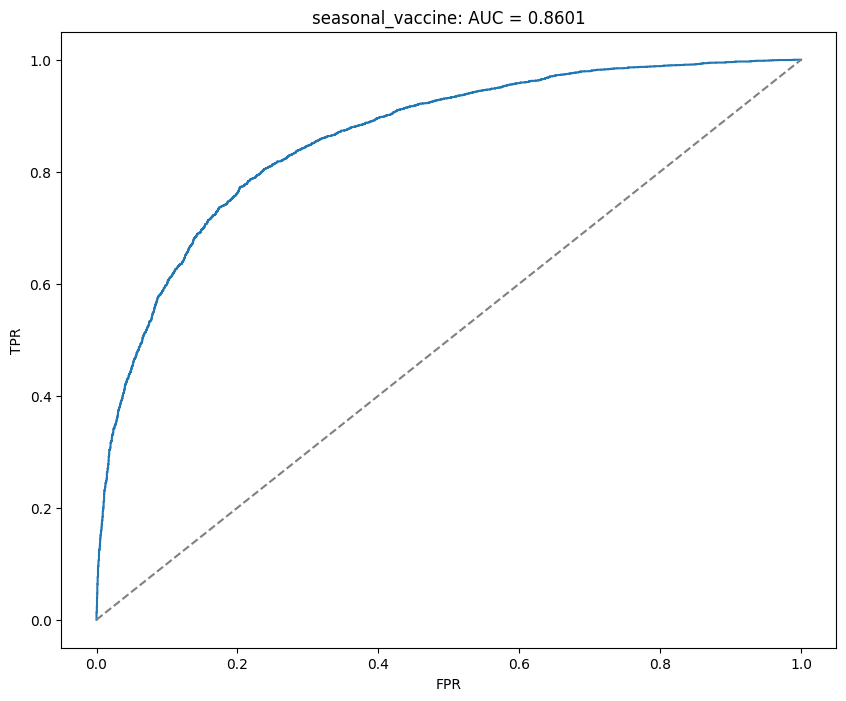

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['seasonal_vaccine'],
    predictions_se,
    'seasonal_vaccine',
    ax=ax
)

In [36]:
roc_auc_score(y_test.seasonal_vaccine, predictions_se)

0.8600556441577139

In [37]:
roc_auc_score(y_test, np.hstack((predictions_xyz, predictions_se)))

0.8646930335407647

In [38]:
final_model_se.fit(train, labels.seasonal_vaccine)

In [39]:
final_se = final_model_se.predict_proba(test)

In [40]:
final_se = final_se[:,1].reshape(-1,1)

In [41]:
final_model.fit(train, labels.xyz_vaccine)

In [42]:
final_xyz = final_model.predict_proba(test)

In [43]:
final_xyz= final_xyz[:,1].reshape(-1,1)

In [44]:
submission_df = pd.read_csv("./submission_format.csv",
                            index_col="respondent_id")

In [45]:
np.testing.assert_array_equal(test.index.values,
                              submission_df.index.values)


submission_df["xyz_vaccine"] = final_xyz
submission_df["seasonal_vaccine"] = final_se

submission_df.head()

,h1n1_vaccine,seasonal_vaccine,xyz_vaccine
respondent_id,,,
26707,0.5,0.214590,0.161993
26708,0.5,0.035344,0.054619
26709,0.5,0.756582,0.299887
26710,0.5,0.892578,0.817990
26711,0.5,0.365941,0.396131


In [49]:
date = pd.Timestamp.now().strftime(format='%Y-%m-%d_%H-%M_')
submission_df.to_csv(f'submssion.csv', index=True)